In [1]:
import os
os.environ["THEANO_FLAGS"]="mode=FAST_RUN, device=gpu2,floatX=float32"
import theano
import keras
import time
import sys

import numpy as np
import Binary_DUDE as DUDE
import Binary_N_DUDE as N_DUDE

from numpy import *
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM, GRU
from keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adadelta
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D
from keras.layers import Merge

### Pre-Generated Data Load ###
data=np.load('/home/ubuntu/Yoon_ICE/Data_Generation&Save/Neural_dude_Data_lena512.npz')

nb_classes=data['nb_classes']
delta=data['delta']
dp=data['dp']
loss_lines=data['loss_lines']
imarray=data['imarray']
im_bin=data['im_bin']
x=data['x']
z=data['z']
z_two=data['z_two']
L=data['L']
L_lower=data['L_lower']
L_new=data['L_new']
#offset=data['offset']

### Make data which this experiment needs ###
n=imarray.shape[0]*imarray.shape[1]
alpha_size=2
mapping_size=3
k_max=40

nb_classes=2
loss_lines=1
dp=n+2*loss_lines*imarray.shape[0]+2*loss_lines*imarray.shape[1]+4*loss_lines**2
offset_pre = np.array(([
            [1,0], [-1,0], [0,1], [0,-1], 
            [1,1], [-1,-1], [-1,1], [1,-1],
            
            [2,0], [-2,0], [0,2], [0,-2], 
            [2,1], [-1,-2], [1,2], [-2,-1], [-1,2], [2,-1], [-2,1], [1,-2],
            [2,2], [-2,-2], [2,-2], [-2,2],
            
            [3,0], [-3,0], [0,3], [0,-3], 
            [3,1], [-1,-3], [1,3], [-3,-1], [-3,1], [1,-3], [-1,3], [3,-1],
            [3,2], [-2,-3], [2,3], [-3,-2], [-2,3], [3,-2], [-3,2], [2,-3],
            [3,3], [-3,-3], [-3,3], [3,-3], 
            
            [4,0], [-4,0], [0,4], [0,-4],
            [-1,4], [1,-4], [4,1], [-4,-1], [-4,1], [4,-1], [1,4], [-1,-4],
            [4,2], [-2,-4], [2,4], [-4,-2], [-2,4], [4,-2], [-4,2], [2,-4],
            [4,3], [-3,-4], [3,4], [-4,-3], [-3,4], [4,-3], [-4,3], [3,-4],
            [4,4], [-4,-4], [-4,4], [4,-4],
            
            [5,0], [-5,0], [0,5], [0,-5], 
            [-1,5], [1,-5], [5,1], [-5,-1], [-5,1], [5,-1], [1,5],[-1,-5],
            [5,2], [-2,-5], [2,5], [-5,-2], [-2,5], [5,-2], [-5,2], [2,-5],
            [5,3], [-3,-5], [3,5], [-5,-3], [-3,5], [5,-3], [-5,3], [3,-5], 
            [5,4], [-4,-5], [4,5], [-5,-4], [-4,5], [5,-4], [-5,4], [4,-5],
            [5,5], [-5,-5], [-5,5], [5,-5], 
            
            [6,0], [-6,0], [0,6], [0,-6], 
            [-1,6], [1,-6], [6,1], [-6,-1], [-6,1], [6,-1], [1,6], [-1,-6],
            [6,2], [-2,-6], [2,6], [-6,-2], [-2,6], [6,-2], [-6,2], [2,-6], 
            [6,3], [-3,-6], [3,6], [-6,-3], [-3,6], [6,-3], [-6,3], [3,-6],
            [6,4], [-4,-6], [4,6], [-6,-4], [-4,6], [6,-4], [-6,4], [4,-6], 
            [5,6], [-5,-6], [6,5], [-6,-5], [-5,6], [6,-5], [-6,5], [5,-6],
            [6,6], [-6,-6], [-6,6], [6,-6],
               
            [7,0], [-7,0], [0,7], [0,-7], 
            [-1,7], [1,-7], [7,1], [-7,-1], [-7,1], [7,-1], [1,7], [-1,-7],
            [7,2], [-2,-7], [2,7], [-7,-2], [-2,7], [7,-2], [-7,2], [2,-7],
            [7,3], [-3,-7], [3,7], [-7,-3], [-3,7], [7,-3], [-7,3], [3,-7], 
            [7,4], [-4,-7], [4,7], [-7,-4], [-4,7], [7,-4], [-7,4], [4,-7],
            [5,7], [-5,-7], [7,5], [-7,-5], [-5,7], [7,-5], [-7,5], [5,-7],
            [7,6], [-7,-6], [6,7], [-6,-7], [-6,7], [6,-7], [-7,6], [7,-6], 
            [7,7], [-7,-7], [-7,7], [7,-7],
            
            [8,0], [-8,0], [0,8], [0,-8],
            [-1,8], [1,-8], [8,1], [-8,-1], [-8,1], [8,-1], [1,8], [-1,-8],
            [8,2], [-2,-8], [2,8], [-8,-2], [-2,8], [8,-2], [-8,2], [2,-8],
            [8,3], [-3,-8], [3,8], [-8,-3], [-3,8], [3,-8], [-3,8], [3,-8],
            [8,4], [-4,-8], [4,8], [-8,-4], [-4,8], [8,-4], [-8,4], [4,-8], 
            [5,8], [-5,-8], [8,5], [-8,-5], [-5,8], [8,-5], [-8,5], [5,-8],
            [8,6], [-8,-6], [6,8], [-6,-8], [-6,8], [6,-8], [-8,6], [8,-6], 
            [8,7], [-8,-7], [-8,7], [8,-7], [7,8], [-7,-8], [-7,8], [7,-8],
            [8,8], [-8,-8], [8,-8], [-8,8],
            
            [9,0], [-9,0], [0,9], [0,-9],
            [-1,9], [1,-9], [9,1], [-9,-1], [-9,1], [9,-1], [1,9], [-1,-9],
            [9,2], [-2,-9], [2,9], [-9,-2], [-2,9], [9,-2], [-9,2], [2,-9],
            [9,3], [-3,-9], [3,9], [-9,-3], [-3,9], [7,-9], [-7,9], [3,-9],
            [9,4], [-4,-9], [4,9], [-9,-4], [-4,9], [9,-4], [-9,4], [4,-9], 
            [5,9], [-5,-9], [9,5], [-9,-5], [-5,9], [9,-5], [-9,5], [5,-9], 
            [9,6], [-9,-6], [6,9], [-6,-9], [-6,9], [6,-9], [-9,6], [9,-6],
            [9,7], [-9,-7], [-9,7], [9,-7], [7,9], [-7,-9], [-7,9], [7,-9],
            [9,8], [-9,-8], [9,-8], [-9,8], [8,9], [-8,-9], [8,-9], [-8,9],
            [9,9], [9,-9], [-9,9], [-9,-9],
               
            [10,0], [-10,0], [0,10], [0,-10], 
            [-1,10], [1,-10], [10,1], [-10,-1], [-10,1], [10,-1], [1,10], [-1,-10],
            [10,2], [-2,-10], [2,10], [-10,-2], [-2,10], [10,-2], [-10,2], [2,-10],
            [10,3], [-3,-10], [3,10], [-10,-3], [-3,10], [3,-10], [-3,10], [3,-10],
            [10,4], [-4,-10], [4,10], [-10,-4], [-4,10], [10,-4], [-10,4], [4,-10],
            [5,10], [-5,-10], [10,5], [-10,-5], [-5,10], [10,-5], [-10,5], [5,-10],
            [10,6], [-10,-6], [6,10], [-6,-10], [-6,10], [6,-10], [-10,6], [10,-6], 
            [10,7], [-10,-7], [-10,7], [10,-7], [7,10], [-7,-10], [-7,10], [7,-10],
            [10,8], [-10,-8], [10,-8], [-10,8], [8,10], [-8,-10], [8,-10], [-8,10],
            [10,9], [10,-9], [-10,9], [-10,-9], [9,10], [9,-10], [-9,10], [-9,-10],
            [10,10], [10,-10], [-10,10], [-10,-10], 
               
            [11,0], [-11,0], [0,11], [0,-11], 
            [-1,11], [1,-11], [11,1], [-11,-1], [-11,1], [11,-1], [1,11], [-1,-11], 
            [11,2], [-2,-11], [2,11], [-11,-2], [-2,11], [11,-2], [-11,2], [2,-11],
            [11,3], [-3,-11], [3,11], [-11,-3], [-3,11], [3,-11], [-3,11], [3,-11],
            [11,4], [-4,-11], [4,11], [-11,-4], [-4,11], [11,-4], [-11,4], [4,-11],
            [5,11], [-5,-11], [11,5], [-11,-5], [-5,11], [11,-5], [-11,5], [5,-11],
            [11,6], [-11,-6], [6,11], [-6,-11], [-6,11], [6,-11], [-11,6], [11,-6], 
            [11,7], [-11,-7], [-11,7], [11,-7], [7,11], [-7,-11], [-7,11], [7,-11],
            [11,8], [-11,-8], [11,-8], [-11,8], [8,11], [-8,-11], [8,-11], [-8,11],
            [11,9], [11,-9], [-11,9], [-11,-9], [9,11], [9,-11], [-9,11], [-9,-11],
            [11,10], [11,-10], [-11,10], [-11,-10], [10,11], [10,-11], [-10,11], [-10,-11],
            [11,11], [11,-11], [-11,11], [-11,-11],
               
            [12,0], [-12,0], [0,12], [0,-12], 
            [-1,12], [1,-12], [12,1], [-12,-1], [-12,1], [12,-1], [1,12], [-1,-12], 
            [12,2], [-2,-12], [2,12], [-12,-2], [-2,12], [12,-2], [-12,2], [2,-12],
            [12,3], [-3,-12], [3,12], [-12,-3], [-3,12], [3,-12], [-3,12], [3,-12], 
            [12,4], [-4,-12], [4,12], [-12,-4], [-4,12], [12,-4], [-12,4], [4,-12], 
            [5,12], [-5,-12], [12,5], [-12,-5], [-5,12], [12,-5], [-12,5], [5,-12],
            [12,6], [-12,-6], [6,12], [-6,-12], [-6,12], [6,-12], [-12,6], [12,-6], 
            [12,7], [-12,-7], [-12,7], [12,-7], [7,12], [-7,-12], [-7,12], [7,-12],
            [12,8], [-12,-8], [12,-8], [-12,8], [8,12], [-8,-12], [8,-12], [-8,12],
            [12,9], [12,-9], [-12,9], [-12,-9], [9,12], [9,-12], [-9,12], [-9,-12],
            [12,10], [12,-10], [-12,10], [-12,-10], [10,12], [10,-12], [-10,12], [-10,-12],
            [12,11], [12,-11], [-12,11], [-12,-11], [11,12], [11,-12], [-11,12], [-11,-12], 
            [12,12],[12,-12],[-12,12],[-12,-12], 
            
            [13,0], [-13,0], [0,13], [0,-13], 
            [-1,13], [1,-13], [13,1], [-13,-1], [-13,1], [13,-1], [1,13], [-1,-13],
            [13,2], [-2,-13], [2,13], [-13,-2], [-2,13], [13,-2], [-13,2], [2,-13], 
            [13,3], [-3,-13], [3,13], [-13,-3], [-3,13], [3,-13], [-3,13], [3,-13],
            [13,4], [-4,-13], [4,13], [-13,-4], [-4,13], [13,-4], [-13,4], [4,-13],
            [5,13], [-5,-13], [13,5], [-13,-5], [-5,13], [13,-5], [-13,5], [5,-13], 
            [13,6], [-13,-6], [6,13], [-6,-13], [-6,13], [6,-13], [-13,6], [13,-6], 
            [13,7], [-13,-7], [-13,7], [13,-7], [7,13], [-7,-13], [-7,13], [7,-13],
            [13,8], [-13,-8], [13,-8], [-13,8], [8,13], [-8,-13], [8,-13], [-8,13],
            [13,9], [13,-9], [-13,9], [-13,-9], [9,13], [9,-13], [-9,13], [-9,-13],
            [13,10], [13,-10], [-13,10], [-13,-10], [10,13], [10,-13], [-10,13], [-10,-13],
            [13,11], [13,-11], [-13,11], [-13,-11], [11,13], [11,-13], [-11,13], [-11,-13],
            [13,12], [13,-12], [-13,12], [-13,-12], [12,13], [12,-13], [-12,13], [-12,-13],
            [13,13], [13,-13], [-13,13], [-13,-13],
                       
            [14,0], [-14,0], [0,14], [0,-14], 
            [-1,14], [1,-14], [14,1], [-14,-1], [-14,1], [14,-1], [1,14], [-1,-14],
            [14,2], [-2,-14],[2,14], [-14,-2], [-2,14], [14,-2], [-14,2], [2,-14], 
            [14,3], [-3,-14], [3,14], [-14,-3], [-3,14], [3,-14], [-3,14], [3,-14],
            [14,4], [-4,-14], [4,14], [-14,-4], [-4,14], [14,-4], [-14,4], [4,-14],
            [5,14], [-5,-14], [14,5], [-14,-5], [-5,14], [14,-5], [-14,5], [5,-14], 
            [14,6], [-14,-6], [6,14], [-6,-14], [-6,14], [6,-14], [-14,6], [14,-6], 
            [14,7], [-14,-7], [-14,7], [14,-7], [7,14], [-7,-14], [-7,14], [7,-14],
            [14,8], [-14,-8], [14,-8], [-14,8], [8,14], [-8,-14], [8,-14], [-8,14],
            [14,9], [14,-9], [-14,9], [-14,-9], [9,14], [9,-14], [-9,14], [-9,-14],
            [14,10], [14,-10], [-14,10], [-14,-10], [10,14], [10,-14], [-10,14], [-10,-14], 
            [14,11], [14,-11], [-14,11], [-14,-11], [11,14], [11,-14], [-11,14], [-11,-14],
            [14,12], [14,-12], [-14,12], [-14,-12], [12,14], [12,-14], [-12,14], [-12,-14],
            [14,13], [14,-13], [-14,13], [-14,-13], [13,14], [13,-14], [-13,14], [-13,-14],
            [14,14], [14,-14], [-14,14], [-14,-14],
            
            [15,0], [-15,0], [0,15], [0,-15], 
            [-1,15], [1,-15], [15,1], [-15,-1], [-15,1], [15,-1], [1,15], [-1,-15],
            [15,2], [-2,-15], [2,15], [-15,-2], [-2,15], [15,-2], [-15,2], [2,-15],
            [15,3], [-3,-15], [3,15], [-15,-3], [-3,15], [3,-15], [-3,15], [3,-15], 
            [15,4], [-4,-15], [4,15], [-15,-4], [-4,15], [15,-4], [-15,4], [4,-15],
            [5,15], [-5,-15], [15,5], [-15,-5], [-5,15], [15,-5], [-15,5], [5,-15], 
            [15,6], [-15,-6], [6,15], [-6,-15], [-6,15], [6,-15],[-15,6], [15,-6], 
            [15,7], [-15,-7], [-15,7], [15,-7], [7,15], [-7,-15], [-7,15], [7,-15],
            [15,8], [-15,-8], [15,-8], [-15,8], [8,15], [-8,-15], [8,-15], [-8,15],
            [15,9], [15,-9], [-15,9], [-15,-9], [9,15], [9,-15], [-9,15], [-9,-15],
            [15,10], [15,-10], [-15,10], [-15,-10], [10,15], [10,-15], [-10,15], [-10,-15],
            [15,11], [15,-11], [-15,11], [-15,-11], [11,15], [11,-15], [-11,15], [-11,-15],
            [15,12], [15,-12], [-15,12], [-15,-12], [12,15], [12,-15], [-12,15], [-12,-15],
            [15,13], [15,-13], [-15,13], [-15,-13], [13,15], [13,-15], [-13,15], [-13,-15],
            [15,14], [15,-14], [-15,14], [-15,-14], [14,15], [14,-15], [-14,15], [-14,-15], 
            [15,15], [15,-15], [-15,15], [-15,-15],
            
            [16,0], [-16,0], [0,16], [0,-16], 
            [-1,16], [1,-16], [16,1], [-16,-1], [-16,1], [16,-1], [1,16], [-1,-16],
            [16,2], [-2,-16],[ 2,16], [-16,-2], [-2,16], [16,-2], [-16,2], [2,-16], 
            [16,3], [-3,-16], [3,16], [-16,-3], [-3,16], [3,-16], [-3,16], [3,-16],
            [16,4], [-4,-16], [4,16], [-16,-4], [-4,16], [16,-4], [-16,4], [4,-16],
            [5,16], [-5,-16], [16,5], [-16,-5], [-5,16], [16,-5], [-16,5], [5,-16],
            [16,6], [-16,-6], [6,16], [-6,-16], [-6,16], [6,-16], [-16,6], [16,-6],
            [16,7], [-16,-7], [-16,7], [16,-7], [7,16], [-7,-16], [-7,16], [7,-16],
            [16,8], [-16,-8], [16,-8], [-16,8], [8,16], [-8,-16], [8,-16], [-8,16],
            [16,9], [16,-9], [-16,9], [-16,-9], [9,16], [9,-16], [-9,16], [-9,-16],
            [16,10], [16,-10], [-16,10], [-16,-10], [10,16], [10,-16], [-10,16], [-10,-16],
            [16,11], [16,-11], [-16,11], [-16,-11], [11,16], [11,-16], [-11,16], [-11,-16],
            [16,12], [16,-12], [-16,12], [-16,-12], [12,16], [12,-16], [-12,16], [-12,-16],
            [16,13], [16,-13], [-16,13], [-16,-13], [13,16], [13,-16], [-13,16], [-13,-16],
            [16,14], [16,-14], [-16,14], [-16,-14], [14,16], [14,-16], [-14,16], [-14,-16],
            [16,15], [16,-15], [-16,15], [-16,-15], [15,16], [15,-16], [-15,16], [-15,-16],
            [16,16], [16,-16], [-16,16], [-16,-16],
            
            [17,0], [-17,0], [0,17], [0,-17], 
            [-1,17], [1,-17], [17,1], [-17,-1], [-17,1], [17,-1], [1,17], [-1,-17],
            [17,2], [-2,-17], [2,17], [-17,-2], [-2,17], [17,-2], [-17,2], [2,-17], 
            [17,3], [-3,-17], [3,17], [-17,-3], [-3,17], [3,-17], [-3,17], [3,-17], 
            [17,4], [-4,-17], [4,17], [-17,-4], [-4,17], [17,-4], [-17,4], [4,-17],
            [5,17], [-5,-17], [17,5], [-17,-5], [-5,17], [17,-5], [-17,5], [5,-17],
            [17,6], [-17,-6], [6,17], [-6,-17], [-6,17], [6,-17],[-17,6], [17,-6],
            [17,7], [-17,-7], [-17,7], [17,-7], [7,17], [-7,-17], [-7,17], [7,-17], 
            [17,8], [-17,-8], [17,-8], [-17,8], [8,17], [-8,-17], [8,-17], [-8,17], 
            [17,9], [17,-9], [-17,9], [-17,-9], [9,17], [9,-17], [-9,17], [-9,-17],
            [17,10], [17,-10], [-17,10], [-17,-10], [10,17], [10,-17], [-10,17], [-10,-17], 
            [17,11], [17,-11], [-17,11], [-17,-11], [11,17], [11,-17], [-11,17], [-11,-17], 
            [17,12], [17,-12], [-17,12], [-17,-12], [12,17], [12,-17], [-12,17], [-12,-17],
            [17,13], [17,-13], [-17,13], [-17,-13], [13,17], [13,-17], [-13,17], [-13,-17],
            [17,14], [17,-14], [-17,14], [-17,-14], [14,17], [14,-17], [-14,17], [-14,-17], 
            [17,15], [17,-15], [-17,15], [-17,-15], [15,17], [15,-17], [-15,17], [-15,-17],
            [17,16], [17,-16], [-17,16], [-17,-16], [16,17], [16,-17], [-16,17], [-16,-17],
            [17,17], [17,-17], [-17,17], [-17,-17],
                        
            [18,0], [-18,0], [0,18], [0,-18], 
            [-1,18], [1,-18], [18,1], [-18,-1], [-18,1], [18,-1], [1,18], [-1,-18],
            [18,2], [-2,-18], [2,18], [-18,-2], [-2,18], [18,-2], [-18,2], [2,-18], 
            [18,3], [-3,-18], [3,18], [-18,-3], [-3,18], [3,-18], [-3,18], [3,-18], 
            [18,4], [-4,-18], [4,18], [-18,-4], [-4,18], [18,-4], [-18,4], [4,-18],
            [5,18], [-5,-18], [18,5], [-18,-5], [-5,18], [18,-5], [-18,5], [5,-18],
            [18,6], [-18,-6], [6,18], [-6,-18], [-6,18], [6,-18],[-18,6], [18,-6],
            [18,7], [-18,-7], [-18,7], [18,-7], [7,18], [-7,-18], [-7,18], [7,-18], 
            [18,8], [-18,-8], [18,-8], [-18,8], [8,18], [-8,-18], [8,-18], [-8,18], 
            [18,9], [18,-9], [-18,9], [-18,-9], [9,18], [9,-18], [-9,18], [-9,-18],
            [18,10], [18,-10], [-18,10], [-18,-10], [10,18], [10,-18], [-10,18], [-10,-18], 
            [18,11], [18,-11], [-18,11], [-18,-11], [11,18], [11,-18], [-11,18], [-11,-18], 
            [18,12], [18,-12], [-18,12], [-18,-12], [12,18], [12,-18], [-12,18], [-12,-18],
            [18,13], [18,-13], [-18,13], [-18,-13], [13,18], [13,-18], [-13,18], [-13,-18],
            [18,14], [18,-14], [-18,14], [-18,-14], [14,18], [14,-18], [-14,18], [-14,-18], 
            [18,15], [18,-15], [-18,15], [-18,-15], [15,18], [15,-18], [-15,18], [-15,-18],
            [18,16], [18,-16], [-18,16], [-18,-16], [16,18], [16,-18], [-16,18], [-16,-18],
            [18,17], [18,-17], [-18,17], [-18,-17], [17,18], [17,-18], [-17,18], [-17,-18],
            [18,18], [18,-18], [-18,18], [-18,-18],

            [19,0], [-19,0], [0,19], [0,-19], 
            [-1,19], [1,-19], [19,1], [-19,-1], [-19,1], [19,-1], [1,19], [-1,-19],
            [19,2], [-2,-19], [2,19], [-19,-2], [-2,19], [19,-2], [-19,2], [2,-19], 
            [19,3], [-3,-19], [3,19], [-19,-3], [-3,19], [3,-19], [-3,19], [3,-19], 
            [19,4], [-4,-19], [4,19], [-19,-4], [-4,19], [19,-4], [-19,4], [4,-19],
            [5,19], [-5,-19], [19,5], [-19,-5], [-5,19], [19,-5], [-19,5], [5,-19],
            [19,6], [-19,-6], [6,19], [-6,-19], [-6,19], [6,-19],[-19,6], [19,-6],
            [19,7], [-19,-7], [-19,7], [19,-7], [7,19], [-7,-19], [-7,19], [7,-19], 
            [19,8], [-19,-8], [19,-8], [-19,8], [8,19], [-8,-19], [8,-19], [-8,19], 
            [19,9], [19,-9], [-19,9], [-19,-9], [9,19], [9,-19], [-9,19], [-9,-19],
            [19,10], [19,-10], [-19,10], [-19,-10], [10,19], [10,-19], [-10,19], [-10,-19], 
            [19,11], [19,-11], [-19,11], [-19,-11], [11,19], [11,-19], [-11,19], [-11,-19], 
            [19,12], [19,-12], [-19,12], [-19,-12], [12,19], [12,-19], [-12,19], [-12,-19],
            [19,13], [19,-13], [-19,13], [-19,-13], [13,19], [13,-19], [-13,19], [-13,-19],
            [19,14], [19,-14], [-19,14], [-19,-14], [14,19], [14,-19], [-14,19], [-14,-19], 
            [19,15], [19,-15], [-19,15], [-19,-15], [15,19], [15,-19], [-15,19], [-15,-19],
            [19,16], [19,-16], [-19,16], [-19,-16], [16,19], [16,-19], [-16,19], [-16,-19],
            [19,17], [19,-17], [-19,17], [-19,-17], [17,19], [17,-19], [-17,19], [-17,-19],
            [19,18], [19,-18], [-19,18], [-19,-18], [18,19], [18,-19], [-18,19], [-18,-19],
            [19,19], [19,-19], [-19,19], [-19,-19],

            [20,0], [-20,0], [0,20], [0,-20], 
            [-1,20], [1,-20], [20,1], [-20,-1], [-20,1], [20,-1], [1,20], [-1,-20],
            [20,2], [-2,-20], [2,20], [-20,-2], [-2,20], [20,-2], [-20,2], [2,-20], 
            [20,3], [-3,-20], [3,20], [-20,-3], [-3,20], [3,-20], [-3,20], [3,-20], 
            [20,4], [-4,-20], [4,20], [-20,-4], [-4,20], [20,-4], [-20,4], [4,-20],
            [5,20], [-5,-20], [20,5], [-20,-5], [-5,20], [20,-5], [-20,5], [5,-20],
            [20,6], [-20,-6], [6,20], [-6,-20], [-6,20], [6,-20],[-20,6], [20,-6],
            [20,7], [-20,-7], [-20,7], [20,-7], [7,20], [-7,-20], [-7,20], [7,-20], 
            [20,8], [-20,-8], [20,-8], [-20,8], [8,20], [-8,-20], [8,-20], [-8,20], 
            [20,9], [20,-9], [-20,9], [-20,-9], [9,20], [9,-20], [-9,20], [-9,-20],
            [20,10], [20,-10], [-20,10], [-20,-10], [10,20], [10,-20], [-10,20], [-10,-20], 
            [20,11], [20,-11], [-20,11], [-20,-11], [11,20], [11,-20], [-11,20], [-11,-20], 
            [20,12], [20,-12], [-20,12], [-20,-12], [12,20], [12,-20], [-12,20], [-12,-20],
            [20,13], [20,-13], [-20,13], [-20,-13], [13,20], [13,-20], [-13,20], [-13,-20],
            [20,14], [20,-14], [-20,14], [-20,-14], [14,20], [14,-20], [-14,20], [-14,-20], 
            [20,15], [20,-15], [-20,15], [-20,-15], [15,20], [15,-20], [-15,20], [-15,-20],
            [20,16], [20,-16], [-20,16], [-20,-16], [16,20], [16,-20], [-16,20], [-16,-20],
            [20,17], [20,-17], [-20,17], [-20,-17], [17,20], [17,-20], [-17,20], [-17,-20],
            [20,18], [20,-18], [-20,18], [-20,-18], [18,20], [18,-20], [-18,20], [-18,-20],
            [20,19], [20,-19], [-20,19], [-20,-19], [19,20], [19,-20], [-19,20], [-19,-20],
            [20,20], [20,-20], [-20,20], [-20,-20],

            [21,0], [-21,0], [0,21], [0,-21], 
            [-1,21], [1,-21], [21,1], [-21,-1], [-21,1], [21,-1], [1,21], [-1,-21],
            [21,2], [-2,-21], [2,21], [-21,-2], [-2,21], [21,-2], [-21,2], [2,-21], 
            [21,3], [-3,-21], [3,21], [-21,-3], [-3,21], [3,-21], [-3,21], [3,-21], 
            [21,4], [-4,-21], [4,21], [-21,-4], [-4,21], [21,-4], [-21,4], [4,-21],
            [5,21], [-5,-21], [21,5], [-21,-5], [-5,21], [21,-5], [-21,5], [5,-21],
            [21,6], [-21,-6], [6,21], [-6,-21], [-6,21], [6,-21],[-21,6], [21,-6],
            [21,7], [-21,-7], [-21,7], [21,-7], [7,21], [-7,-21], [-7,21], [7,-21], 
            [21,8], [-21,-8], [21,-8], [-21,8], [8,21], [-8,-21], [8,-21], [-8,21], 
            [21,9], [21,-9], [-21,9], [-21,-9], [9,21], [9,-21], [-9,21], [-9,-21],
            [21,10], [21,-10], [-21,10], [-21,-10], [10,21], [10,-21], [-10,21], [-10,-21], 
            [21,11], [21,-11], [-21,11], [-21,-11], [11,21], [11,-21], [-11,21], [-11,-21], 
            [21,12], [21,-12], [-21,12], [-21,-12], [12,21], [12,-21], [-12,21], [-12,-21],
            [21,13], [21,-13], [-21,13], [-21,-13], [13,21], [13,-21], [-13,21], [-13,-21],
            [21,14], [21,-14], [-21,14], [-21,-14], [14,21], [14,-21], [-14,21], [-14,-21], 
            [21,15], [21,-15], [-21,15], [-21,-15], [15,21], [15,-21], [-15,21], [-15,-21],
            [21,16], [21,-16], [-21,16], [-21,-16], [16,21], [16,-21], [-16,21], [-16,-21],
            [21,17], [21,-17], [-21,17], [-21,-17], [17,21], [17,-21], [-17,21], [-17,-21],
            [21,18], [21,-18], [-21,18], [-21,-18], [18,21], [18,-21], [-18,21], [-18,-21],
            [21,19], [21,-19], [-21,19], [-21,-19], [19,21], [19,-21], [-19,21], [-19,-21],
            [21,20], [21,-20], [-21,20], [-21,-20], [20,21], [20,-21], [-20,21], [-20,-21],
            [21,21], [21,-21], [-21,21], [-21,-21],

            [22,0], [-22,0], [0,22], [0,-22], 
            [-1,22], [1,-22], [22,1], [-22,-1], [-22,1], [22,-1], [1,22], [-1,-22],
            [22,2], [-2,-22], [2,22], [-22,-2], [-2,22], [22,-2], [-22,2], [2,-22], 
            [22,3], [-3,-22], [3,22], [-22,-3], [-3,22], [3,-22], [-3,22], [3,-22], 
            [22,4], [-4,-22], [4,22], [-22,-4], [-4,22], [22,-4], [-22,4], [4,-22],
            [5,22], [-5,-22], [22,5], [-22,-5], [-5,22], [22,-5], [-22,5], [5,-22],
            [22,6], [-22,-6], [6,22], [-6,-22], [-6,22], [6,-22],[-22,6], [22,-6],
            [22,7], [-22,-7], [-22,7], [22,-7], [7,22], [-7,-22], [-7,22], [7,-22], 
            [22,8], [-22,-8], [22,-8], [-22,8], [8,22], [-8,-22], [8,-22], [-8,22], 
            [22,9], [22,-9], [-22,9], [-22,-9], [9,22], [9,-22], [-9,22], [-9,-22],
            [22,10], [22,-10], [-22,10], [-22,-10], [10,22], [10,-22], [-10,22], [-10,-22], 
            [22,11], [22,-11], [-22,11], [-22,-11], [11,22], [11,-22], [-11,22], [-11,-22], 
            [22,12], [22,-12], [-22,12], [-22,-12], [12,22], [12,-22], [-12,22], [-12,-22],
            [22,13], [22,-13], [-22,13], [-22,-13], [13,22], [13,-22], [-13,22], [-13,-22],
            [22,14], [22,-14], [-22,14], [-22,-14], [14,22], [14,-22], [-14,22], [-14,-22], 
            [22,15], [22,-15], [-22,15], [-22,-15], [15,22], [15,-22], [-15,22], [-15,-22],
            [22,16], [22,-16], [-22,16], [-22,-16], [16,22], [16,-22], [-16,22], [-16,-22],
            [22,17], [22,-17], [-22,17], [-22,-17], [17,22], [17,-22], [-17,22], [-17,-22],
            [22,18], [22,-18], [-22,18], [-22,-18], [18,22], [18,-22], [-18,22], [-18,-22],
            [22,19], [22,-19], [-22,19], [-22,-19], [19,22], [19,-22], [-19,22], [-19,-22],
            [22,20], [22,-20], [-22,20], [-22,-20], [20,22], [20,-22], [-20,22], [-20,-22],
            [22,21], [22,-21], [-22,21], [-22,-21], [21,22], [21,-22], [-21,22], [-21,-22],
            [22,22], [22,-22], [-22,22], [-22,-22],

            [23,0], [-23,0], [0,23], [0,-23], 
            [-1,23], [1,-23], [23,1], [-23,-1], [-23,1], [23,-1], [1,23], [-1,-23],
            [23,2], [-2,-23], [2,23], [-23,-2], [-2,23], [23,-2], [-23,2], [2,-23], 
            [23,3], [-3,-23], [3,23], [-23,-3], [-3,23], [3,-23], [-3,23], [3,-23], 
            [23,4], [-4,-23], [4,23], [-23,-4], [-4,23], [23,-4], [-23,4], [4,-23],
            [5,23], [-5,-23], [23,5], [-23,-5], [-5,23], [23,-5], [-23,5], [5,-23],
            [23,6], [-23,-6], [6,23], [-6,-23], [-6,23], [6,-23],[-23,6], [23,-6],
            [23,7], [-23,-7], [-23,7], [23,-7], [7,23], [-7,-23], [-7,23], [7,-23], 
            [23,8], [-23,-8], [23,-8], [-23,8], [8,23], [-8,-23], [8,-23], [-8,23], 
            [23,9], [23,-9], [-23,9], [-23,-9], [9,23], [9,-23], [-9,23], [-9,-23],
            [23,10], [23,-10], [-23,10], [-23,-10], [10,23], [10,-23], [-10,23], [-10,-23], 
            [23,11], [23,-11], [-23,11], [-23,-11], [11,23], [11,-23], [-11,23], [-11,-23], 
            [23,12], [23,-12], [-23,12], [-23,-12], [12,23], [12,-23], [-12,23], [-12,-23],
            [23,13], [23,-13], [-23,13], [-23,-13], [13,23], [13,-23], [-13,23], [-13,-23],
            [23,14], [23,-14], [-23,14], [-23,-14], [14,23], [14,-23], [-14,23], [-14,-23], 
            [23,15], [23,-15], [-23,15], [-23,-15], [15,23], [15,-23], [-15,23], [-15,-23],
            [23,16], [23,-16], [-23,16], [-23,-16], [16,23], [16,-23], [-16,23], [-16,-23],
            [23,17], [23,-17], [-23,17], [-23,-17], [17,23], [17,-23], [-17,23], [-17,-23],
            [23,18], [23,-18], [-23,18], [-23,-18], [18,23], [18,-23], [-18,23], [-18,-23],
            [23,19], [23,-19], [-23,19], [-23,-19], [19,23], [19,-23], [-19,23], [-19,-23],
            [23,20], [23,-20], [-23,20], [-23,-20], [20,23], [20,-23], [-20,23], [-20,-23],
            [23,21], [23,-21], [-23,21], [-23,-21], [21,23], [21,-23], [-21,23], [-21,-23],
            [23,22], [23,-22], [-23,22], [-23,-22], [22,23], [22,-23], [-22,23], [-22,-23],
            [23,23], [23,-23], [-23,23], [-23,-23],

            [24,0], [-24,0], [0,24], [0,-24], 
            [-1,24], [1,-24], [24,1], [-24,-1], [-24,1], [24,-1], [1,24], [-1,-24],
            [24,2], [-2,-24], [2,24], [-24,-2], [-2,24], [24,-2], [-24,2], [2,-24], 
            [24,3], [-3,-24], [3,24], [-24,-3], [-3,24], [3,-24], [-3,24], [3,-24], 
            [24,4], [-4,-24], [4,24], [-24,-4], [-4,24], [24,-4], [-24,4], [4,-24],
            [5,24], [-5,-24], [24,5], [-24,-5], [-5,24], [24,-5], [-24,5], [5,-24],
            [24,6], [-24,-6], [6,24], [-6,-24], [-6,24], [6,-24],[-24,6], [24,-6],
            [24,7], [-24,-7], [-24,7], [24,-7], [7,24], [-7,-24], [-7,24], [7,-24], 
            [24,8], [-24,-8], [24,-8], [-24,8], [8,24], [-8,-24], [8,-24], [-8,24], 
            [24,9], [24,-9], [-24,9], [-24,-9], [9,24], [9,-24], [-9,24], [-9,-24],
            [24,10], [24,-10], [-24,10], [-24,-10], [10,24], [10,-24], [-10,24], [-10,-24], 
            [24,11], [24,-11], [-24,11], [-24,-11], [11,24], [11,-24], [-11,24], [-11,-24], 
            [24,12], [24,-12], [-24,12], [-24,-12], [12,24], [12,-24], [-12,24], [-12,-24],
            [24,13], [24,-13], [-24,13], [-24,-13], [13,24], [13,-24], [-13,24], [-13,-24],
            [24,14], [24,-14], [-24,14], [-24,-14], [14,24], [14,-24], [-14,24], [-14,-24], 
            [24,15], [24,-15], [-24,15], [-24,-15], [15,24], [15,-24], [-15,24], [-15,-24],
            [24,16], [24,-16], [-24,16], [-24,-16], [16,24], [16,-24], [-16,24], [-16,-24],
            [24,17], [24,-17], [-24,17], [-24,-17], [17,24], [17,-24], [-17,24], [-17,-24],
            [24,18], [24,-18], [-24,18], [-24,-18], [18,24], [18,-24], [-18,24], [-18,-24],
            [24,19], [24,-19], [-24,19], [-24,-19], [19,24], [19,-24], [-19,24], [-19,-24],
            [24,20], [24,-20], [-24,20], [-24,-20], [20,24], [20,-24], [-20,24], [-20,-24],
            [24,21], [24,-21], [-24,21], [-24,-21], [21,24], [21,-24], [-21,24], [-21,-24],
            [24,22], [24,-22], [-24,22], [-24,-22], [22,24], [22,-24], [-22,24], [-22,-24],
            [24,23], [24,-23], [-24,23], [-24,-23], [23,24], [23,-24], [-23,24], [-23,-24],
            [24,24], [24,-24], [-24,24], [-24,-24],

            [25,0], [-25,0], [0,25], [0,-25], 
            [-1,25], [1,-25], [25,1], [-25,-1], [-25,1], [25,-1], [1,25], [-1,-25],
            [25,2], [-2,-25], [2,25], [-25,-2], [-2,25], [25,-2], [-25,2], [2,-25], 
            [25,3], [-3,-25], [3,25], [-25,-3], [-3,25], [3,-25], [-3,25], [3,-25], 
            [25,4], [-4,-25], [4,25], [-25,-4], [-4,25], [25,-4], [-25,4], [4,-25],
            [5,25], [-5,-25], [25,5], [-25,-5], [-5,25], [25,-5], [-25,5], [5,-25],
            [25,6], [-25,-6], [6,25], [-6,-25], [-6,25], [6,-25],[-25,6], [25,-6],
            [25,7], [-25,-7], [-25,7], [25,-7], [7,25], [-7,-25], [-7,25], [7,-25], 
            [25,8], [-25,-8], [25,-8], [-25,8], [8,25], [-8,-25], [8,-25], [-8,25], 
            [25,9], [25,-9], [-25,9], [-25,-9], [9,25], [9,-25], [-9,25], [-9,-25],
            [25,10], [25,-10], [-25,10], [-25,-10], [10,25], [10,-25], [-10,25], [-10,-25], 
            [25,11], [25,-11], [-25,11], [-25,-11], [11,25], [11,-25], [-11,25], [-11,-25], 
            [25,12], [25,-12], [-25,12], [-25,-12], [12,25], [12,-25], [-12,25], [-12,-25],
            [25,13], [25,-13], [-25,13], [-25,-13], [13,25], [13,-25], [-13,25], [-13,-25],
            [25,14], [25,-14], [-25,14], [-25,-14], [14,25], [14,-25], [-14,25], [-14,-25], 
            [25,15], [25,-15], [-25,15], [-25,-15], [15,25], [15,-25], [-15,25], [-15,-25],
            [25,16], [25,-16], [-25,16], [-25,-16], [16,25], [16,-25], [-16,25], [-16,-25],
            [25,17], [25,-17], [-25,17], [-25,-17], [17,25], [17,-25], [-17,25], [-17,-25],
            [25,18], [25,-18], [-25,18], [-25,-18], [18,25], [18,-25], [-18,25], [-18,-25],
            [25,19], [25,-19], [-25,19], [-25,-19], [19,25], [19,-25], [-19,25], [-19,-25],
            [25,20], [25,-20], [-25,20], [-25,-20], [20,25], [20,-25], [-20,25], [-20,-25],
            [25,21], [25,-21], [-25,21], [-25,-21], [21,25], [21,-25], [-21,25], [-21,-25],
            [25,22], [25,-22], [-25,22], [-25,-22], [22,25], [22,-25], [-22,25], [-22,-25],
            [25,23], [25,-23], [-25,23], [-25,-23], [23,25], [23,-25], [-23,25], [-23,-25],
            [25,24], [25,-24], [-25,24], [-25,-24], [24,25], [24,-25], [-24,25], [-24,-25],
            [25,25], [25,-25], [-25,25], [-25,-25],

            [26,0], [-26,0], [0,26], [0,-26], 
            [-1,26], [1,-26], [26,1], [-26,-1], [-26,1], [26,-1], [1,26], [-1,-26],
            [26,2], [-2,-26], [2,26], [-26,-2], [-2,26], [26,-2], [-26,2], [2,-26], 
            [26,3], [-3,-26], [3,26], [-26,-3], [-3,26], [3,-26], [-3,26], [3,-26], 
            [26,4], [-4,-26], [4,26], [-26,-4], [-4,26], [26,-4], [-26,4], [4,-26],
            [5,26], [-5,-26], [26,5], [-26,-5], [-5,26], [26,-5], [-26,5], [5,-26],
            [26,6], [-26,-6], [6,26], [-6,-26], [-6,26], [6,-26],[-26,6], [26,-6],
            [26,7], [-26,-7], [-26,7], [26,-7], [7,26], [-7,-26], [-7,26], [7,-26], 
            [26,8], [-26,-8], [26,-8], [-26,8], [8,26], [-8,-26], [8,-26], [-8,26], 
            [26,9], [26,-9], [-26,9], [-26,-9], [9,26], [9,-26], [-9,26], [-9,-26],
            [26,10], [26,-10], [-26,10], [-26,-10], [10,26], [10,-26], [-10,26], [-10,-26], 
            [26,11], [26,-11], [-26,11], [-26,-11], [11,26], [11,-26], [-11,26], [-11,-26], 
            [26,12], [26,-12], [-26,12], [-26,-12], [12,26], [12,-26], [-12,26], [-12,-26],
            [26,13], [26,-13], [-26,13], [-26,-13], [13,26], [13,-26], [-13,26], [-13,-26],
            [26,14], [26,-14], [-26,14], [-26,-14], [14,26], [14,-26], [-14,26], [-14,-26], 
            [26,15], [26,-15], [-26,15], [-26,-15], [15,26], [15,-26], [-15,26], [-15,-26],
            [26,16], [26,-16], [-26,16], [-26,-16], [16,26], [16,-26], [-16,26], [-16,-26],
            [26,17], [26,-17], [-26,17], [-26,-17], [17,26], [17,-26], [-17,26], [-17,-26],
            [26,18], [26,-18], [-26,18], [-26,-18], [18,26], [18,-26], [-18,26], [-18,-26],
            [26,19], [26,-19], [-26,19], [-26,-19], [19,26], [19,-26], [-19,26], [-19,-26],
            [26,20], [26,-20], [-26,20], [-26,-20], [20,26], [20,-26], [-20,26], [-20,-26],
            [26,21], [26,-21], [-26,21], [-26,-21], [21,26], [21,-26], [-21,26], [-21,-26],
            [26,22], [26,-22], [-26,22], [-26,-22], [22,26], [22,-26], [-22,26], [-22,-26],
            [26,23], [26,-23], [-26,23], [-26,-23], [23,26], [23,-26], [-23,26], [-23,-26],
            [26,24], [26,-24], [-26,24], [-26,-24], [24,26], [24,-26], [-24,26], [-24,-26],
            [26,25], [26,-25], [-26,25], [-26,-25], [25,26], [25,-26], [-25,26], [-25,-26],
            [26,26], [26,-26], [-26,26], [-26,-26],

            [27,0], [-27,0], [0,27], [0,-27], 
            [-1,27], [1,-27], [27,1], [-27,-1], [-27,1], [27,-1], [1,27], [-1,-27],
            [27,2], [-2,-27], [2,27], [-27,-2], [-2,27], [27,-2], [-27,2], [2,-27], 
            [27,3], [-3,-27], [3,27], [-27,-3], [-3,27], [3,-27], [-3,27], [3,-27], 
            [27,4], [-4,-27], [4,27], [-27,-4], [-4,27], [27,-4], [-27,4], [4,-27],
            [5,27], [-5,-27], [27,5], [-27,-5], [-5,27], [27,-5], [-27,5], [5,-27],
            [27,6], [-27,-6], [6,27], [-6,-27], [-6,27], [6,-27],[-27,6], [27,-6],
            [27,7], [-27,-7], [-27,7], [27,-7], [7,27], [-7,-27], [-7,27], [7,-27], 
            [27,8], [-27,-8], [27,-8], [-27,8], [8,27], [-8,-27], [8,-27], [-8,27], 
            [27,9], [27,-9], [-27,9], [-27,-9], [9,27], [9,-27], [-9,27], [-9,-27],
            [27,10], [27,-10], [-27,10], [-27,-10], [10,27], [10,-27], [-10,27], [-10,-27], 
            [27,11], [27,-11], [-27,11], [-27,-11], [11,27], [11,-27], [-11,27], [-11,-27], 
            [27,12], [27,-12], [-27,12], [-27,-12], [12,27], [12,-27], [-12,27], [-12,-27],
            [27,13], [27,-13], [-27,13], [-27,-13], [13,27], [13,-27], [-13,27], [-13,-27],
            [27,14], [27,-14], [-27,14], [-27,-14], [14,27], [14,-27], [-14,27], [-14,-27], 
            [27,15], [27,-15], [-27,15], [-27,-15], [15,27], [15,-27], [-15,27], [-15,-27],
            [27,16], [27,-16], [-27,16], [-27,-16], [16,27], [16,-27], [-16,27], [-16,-27],
            [27,17], [27,-17], [-27,17], [-27,-17], [17,27], [17,-27], [-17,27], [-17,-27],
            [27,18], [27,-18], [-27,18], [-27,-18], [18,27], [18,-27], [-18,27], [-18,-27],
            [27,19], [27,-19], [-27,19], [-27,-19], [19,27], [19,-27], [-19,27], [-19,-27],
            [27,20], [27,-20], [-27,20], [-27,-20], [20,27], [20,-27], [-20,27], [-20,-27],
            [27,21], [27,-21], [-27,21], [-27,-21], [21,27], [21,-27], [-21,27], [-21,-27],
            [27,22], [27,-22], [-27,22], [-27,-22], [22,27], [22,-27], [-22,27], [-22,-27],
            [27,23], [27,-23], [-27,23], [-27,-23], [23,27], [23,-27], [-23,27], [-23,-27],
            [27,24], [27,-24], [-27,24], [-27,-24], [24,27], [24,-27], [-24,27], [-24,-27],
            [27,25], [27,-25], [-27,25], [-27,-25], [25,27], [25,-27], [-25,27], [-25,-27],
            [27,26], [27,-26], [-27,26], [-27,-26], [26,27], [26,-27], [-26,27], [-26,-27],
            [27,27], [27,-27], [-27,27], [-27,-27],

            [28,0], [-28,0], [0,28], [0,-28], 
            [-1,28], [1,-28], [28,1], [-28,-1], [-28,1], [28,-1], [1,28], [-1,-28],
            [28,2], [-2,-28], [2,28], [-28,-2], [-2,28], [28,-2], [-28,2], [2,-28], 
            [28,3], [-3,-28], [3,28], [-28,-3], [-3,28], [3,-28], [-3,28], [3,-28], 
            [28,4], [-4,-28], [4,28], [-28,-4], [-4,28], [28,-4], [-28,4], [4,-28],
            [5,28], [-5,-28], [28,5], [-28,-5], [-5,28], [28,-5], [-28,5], [5,-28],
            [28,6], [-28,-6], [6,28], [-6,-28], [-6,28], [6,-28],[-28,6], [28,-6],
            [28,7], [-28,-7], [-28,7], [28,-7], [7,28], [-7,-28], [-7,28], [7,-28], 
            [28,8], [-28,-8], [28,-8], [-28,8], [8,28], [-8,-28], [8,-28], [-8,28], 
            [28,9], [28,-9], [-28,9], [-28,-9], [9,28], [9,-28], [-9,28], [-9,-28],
            [28,10], [28,-10], [-28,10], [-28,-10], [10,28], [10,-28], [-10,28], [-10,-28], 
            [28,11], [28,-11], [-28,11], [-28,-11], [11,28], [11,-28], [-11,28], [-11,-28], 
            [28,12], [28,-12], [-28,12], [-28,-12], [12,28], [12,-28], [-12,28], [-12,-28],
            [28,13], [28,-13], [-28,13], [-28,-13], [13,28], [13,-28], [-13,28], [-13,-28],
            [28,14], [28,-14], [-28,14], [-28,-14], [14,28], [14,-28], [-14,28], [-14,-28], 
            [28,15], [28,-15], [-28,15], [-28,-15], [15,28], [15,-28], [-15,28], [-15,-28],
            [28,16], [28,-16], [-28,16], [-28,-16], [16,28], [16,-28], [-16,28], [-16,-28],
            [28,17], [28,-17], [-28,17], [-28,-17], [17,28], [17,-28], [-17,28], [-17,-28],
            [28,18], [28,-18], [-28,18], [-28,-18], [18,28], [18,-28], [-18,28], [-18,-28],
            [28,19], [28,-19], [-28,19], [-28,-19], [19,28], [19,-28], [-19,28], [-19,-28],
            [28,20], [28,-20], [-28,20], [-28,-20], [20,28], [20,-28], [-20,28], [-20,-28],
            [28,21], [28,-21], [-28,21], [-28,-21], [21,28], [21,-28], [-21,28], [-21,-28],
            [28,22], [28,-22], [-28,22], [-28,-22], [22,28], [22,-28], [-22,28], [-22,-28],
            [28,23], [28,-23], [-28,23], [-28,-23], [23,28], [23,-28], [-23,28], [-23,-28],
            [28,24], [28,-24], [-28,24], [-28,-24], [24,28], [24,-28], [-24,28], [-24,-28],
            [28,25], [28,-25], [-28,25], [-28,-25], [25,28], [25,-28], [-25,28], [-25,-28],
            [28,26], [28,-26], [-28,26], [-28,-26], [26,28], [26,-28], [-26,28], [-26,-28],
            [28,27], [28,-27], [-28,27], [-28,-27], [27,28], [27,-28], [-27,28], [-27,-28],
            [28,28], [28,-28], [-28,28], [-28,-28],

            [29,0], [-29,0], [0,29], [0,-29], 
            [-1,29], [1,-29], [29,1], [-29,-1], [-29,1], [29,-1], [1,29], [-1,-29],
            [29,2], [-2,-29], [2,29], [-29,-2], [-2,29], [29,-2], [-29,2], [2,-29], 
            [29,3], [-3,-29], [3,29], [-29,-3], [-3,29], [3,-29], [-3,29], [3,-29], 
            [29,4], [-4,-29], [4,29], [-29,-4], [-4,29], [29,-4], [-29,4], [4,-29],
            [5,29], [-5,-29], [29,5], [-29,-5], [-5,29], [29,-5], [-29,5], [5,-29],
            [29,6], [-29,-6], [6,29], [-6,-29], [-6,29], [6,-29],[-29,6], [29,-6],
            [29,7], [-29,-7], [-29,7], [29,-7], [7,29], [-7,-29], [-7,29], [7,-29], 
            [29,8], [-29,-8], [29,-8], [-29,8], [8,29], [-8,-29], [8,-29], [-8,29], 
            [29,9], [29,-9], [-29,9], [-29,-9], [9,29], [9,-29], [-9,29], [-9,-29],
            [29,10], [29,-10], [-29,10], [-29,-10], [10,29], [10,-29], [-10,29], [-10,-29], 
            [29,11], [29,-11], [-29,11], [-29,-11], [11,29], [11,-29], [-11,29], [-11,-29], 
            [29,12], [29,-12], [-29,12], [-29,-12], [12,29], [12,-29], [-12,29], [-12,-29],
            [29,13], [29,-13], [-29,13], [-29,-13], [13,29], [13,-29], [-13,29], [-13,-29],
            [29,14], [29,-14], [-29,14], [-29,-14], [14,29], [14,-29], [-14,29], [-14,-29], 
            [29,15], [29,-15], [-29,15], [-29,-15], [15,29], [15,-29], [-15,29], [-15,-29],
            [29,16], [29,-16], [-29,16], [-29,-16], [16,29], [16,-29], [-16,29], [-16,-29],
            [29,17], [29,-17], [-29,17], [-29,-17], [17,29], [17,-29], [-17,29], [-17,-29],
            [29,18], [29,-18], [-29,18], [-29,-18], [18,29], [18,-29], [-18,29], [-18,-29],
            [29,19], [29,-19], [-29,19], [-29,-19], [19,29], [19,-29], [-19,29], [-19,-29],
            [29,20], [29,-20], [-29,20], [-29,-20], [20,29], [20,-29], [-20,29], [-20,-29],
            [29,21], [29,-21], [-29,21], [-29,-21], [21,29], [21,-29], [-21,29], [-21,-29],
            [29,22], [29,-22], [-29,22], [-29,-22], [22,29], [22,-29], [-22,29], [-22,-29],
            [29,23], [29,-23], [-29,23], [-29,-23], [23,29], [23,-29], [-23,29], [-23,-29],
            [29,24], [29,-24], [-29,24], [-29,-24], [24,29], [24,-29], [-24,29], [-24,-29],
            [29,25], [29,-25], [-29,25], [-29,-25], [25,29], [25,-29], [-25,29], [-25,-29],
            [29,26], [29,-26], [-29,26], [-29,-26], [26,29], [26,-29], [-26,29], [-26,-29],
            [29,27], [29,-27], [-29,27], [-29,-27], [27,29], [27,-29], [-27,29], [-27,-29],
            [29,28], [29,-28], [-29,28], [-29,-28], [28,29], [28,-29], [-28,29], [-28,-29],
            [29,29], [29,-29], [-29,29], [-29,-29],

            [30,0], [-30,0], [0,30], [0,-30], 
            [-1,30], [1,-30], [30,1], [-30,-1], [-30,1], [30,-1], [1,30], [-1,-30],
            [30,2], [-2,-30], [2,30], [-30,-2], [-2,30], [30,-2], [-30,2], [2,-30], 
            [30,3], [-3,-30], [3,30], [-30,-3], [-3,30], [3,-30], [-3,30], [3,-30], 
            [30,4], [-4,-30], [4,30], [-30,-4], [-4,30], [30,-4], [-30,4], [4,-30],
            [5,30], [-5,-30], [30,5], [-30,-5], [-5,30], [30,-5], [-30,5], [5,-30],
            [30,6], [-30,-6], [6,30], [-6,-30], [-6,30], [6,-30],[-30,6], [30,-6],
            [30,7], [-30,-7], [-30,7], [30,-7], [7,30], [-7,-30], [-7,30], [7,-30], 
            [30,8], [-30,-8], [30,-8], [-30,8], [8,30], [-8,-30], [8,-30], [-8,30], 
            [30,9], [30,-9], [-30,9], [-30,-9], [9,30], [9,-30], [-9,30], [-9,-30],
            [30,10], [30,-10], [-30,10], [-30,-10], [10,30], [10,-30], [-10,30], [-10,-30], 
            [30,11], [30,-11], [-30,11], [-30,-11], [11,30], [11,-30], [-11,30], [-11,-30], 
            [30,12], [30,-12], [-30,12], [-30,-12], [12,30], [12,-30], [-12,30], [-12,-30],
            [30,13], [30,-13], [-30,13], [-30,-13], [13,30], [13,-30], [-13,30], [-13,-30],
            [30,14], [30,-14], [-30,14], [-30,-14], [14,30], [14,-30], [-14,30], [-14,-30], 
            [30,15], [30,-15], [-30,15], [-30,-15], [15,30], [15,-30], [-15,30], [-15,-30],
            [30,16], [30,-16], [-30,16], [-30,-16], [16,30], [16,-30], [-16,30], [-16,-30],
            [30,17], [30,-17], [-30,17], [-30,-17], [17,30], [17,-30], [-17,30], [-17,-30],
            [30,18], [30,-18], [-30,18], [-30,-18], [18,30], [18,-30], [-18,30], [-18,-30],
            [30,19], [30,-19], [-30,19], [-30,-19], [19,30], [19,-30], [-19,30], [-19,-30],
            [30,20], [30,-20], [-30,20], [-30,-20], [20,30], [20,-30], [-20,30], [-20,-30],
            [30,21], [30,-21], [-30,21], [-30,-21], [21,30], [21,-30], [-21,30], [-21,-30],
            [30,22], [30,-22], [-30,22], [-30,-22], [22,30], [22,-30], [-22,30], [-22,-30],
            [30,23], [30,-23], [-30,23], [-30,-23], [23,30], [23,-30], [-23,30], [-23,-30],
            [30,24], [30,-24], [-30,24], [-30,-24], [24,30], [24,-30], [-24,30], [-24,-30],
            [30,25], [30,-25], [-30,25], [-30,-25], [25,30], [25,-30], [-25,30], [-25,-30],
            [30,26], [30,-26], [-30,26], [-30,-26], [26,30], [26,-30], [-26,30], [-26,-30],
            [30,27], [30,-27], [-30,27], [-30,-27], [27,30], [27,-30], [-27,30], [-27,-30],
            [30,28], [30,-28], [-30,28], [-30,-28], [28,30], [28,-30], [-28,30], [-28,-30],
            [30,29], [30,-29], [-30,29], [-30,-29], [29,30], [29,-30], [-29,30], [-29,-30],
            [30,30], [30,-30], [-30,30], [-30,-30],

            [31,0], [-31,0], [0,31], [0,-31], 
            [-1,31], [1,-31], [31,1], [-31,-1], [-31,1], [31,-1], [1,31], [-1,-31],
            [31,2], [-2,-31], [2,31], [-31,-2], [-2,31], [31,-2], [-31,2], [2,-31], 
            [31,3], [-3,-31], [3,31], [-31,-3], [-3,31], [3,-31], [-3,31], [3,-31], 
            [31,4], [-4,-31], [4,31], [-31,-4], [-4,31], [31,-4], [-31,4], [4,-31],
            [5,31], [-5,-31], [31,5], [-31,-5], [-5,31], [31,-5], [-31,5], [5,-31],
            [31,6], [-31,-6], [6,31], [-6,-31], [-6,31], [6,-31],[-31,6], [31,-6],
            [31,7], [-31,-7], [-31,7], [31,-7], [7,31], [-7,-31], [-7,31], [7,-31], 
            [31,8], [-31,-8], [31,-8], [-31,8], [8,31], [-8,-31], [8,-31], [-8,31], 
            [31,9], [31,-9], [-31,9], [-31,-9], [9,31], [9,-31], [-9,31], [-9,-31],
            [31,10], [31,-10], [-31,10], [-31,-10], [10,31], [10,-31], [-10,31], [-10,-31], 
            [31,11], [31,-11], [-31,11], [-31,-11], [11,31], [11,-31], [-11,31], [-11,-31], 
            [31,12], [31,-12], [-31,12], [-31,-12], [12,31], [12,-31], [-12,31], [-12,-31],
            [31,13], [31,-13], [-31,13], [-31,-13], [13,31], [13,-31], [-13,31], [-13,-31],
            [31,14], [31,-14], [-31,14], [-31,-14], [14,31], [14,-31], [-14,31], [-14,-31], 
            [31,15], [31,-15], [-31,15], [-31,-15], [15,31], [15,-31], [-15,31], [-15,-31],
            [31,16], [31,-16], [-31,16], [-31,-16], [16,31], [16,-31], [-16,31], [-16,-31],
            [31,17], [31,-17], [-31,17], [-31,-17], [17,31], [17,-31], [-17,31], [-17,-31],
            [31,18], [31,-18], [-31,18], [-31,-18], [18,31], [18,-31], [-18,31], [-18,-31],
            [31,19], [31,-19], [-31,19], [-31,-19], [19,31], [19,-31], [-19,31], [-19,-31],
            [31,20], [31,-20], [-31,20], [-31,-20], [20,31], [20,-31], [-20,31], [-20,-31],
            [31,21], [31,-21], [-31,21], [-31,-21], [21,31], [21,-31], [-21,31], [-21,-31],
            [31,22], [31,-22], [-31,22], [-31,-22], [22,31], [22,-31], [-22,31], [-22,-31],
            [31,23], [31,-23], [-31,23], [-31,-23], [23,31], [23,-31], [-23,31], [-23,-31],
            [31,24], [31,-24], [-31,24], [-31,-24], [24,31], [24,-31], [-24,31], [-24,-31],
            [31,25], [31,-25], [-31,25], [-31,-25], [25,31], [25,-31], [-25,31], [-25,-31],
            [31,26], [31,-26], [-31,26], [-31,-26], [26,31], [26,-31], [-26,31], [-26,-31],
            [31,27], [31,-27], [-31,27], [-31,-27], [27,31], [27,-31], [-27,31], [-27,-31],
            [31,28], [31,-28], [-31,28], [-31,-28], [28,31], [28,-31], [-28,31], [-28,-31],
            [31,29], [31,-29], [-31,29], [-31,-29], [29,31], [29,-31], [-29,31], [-29,-31],
            [31,30], [31,-30], [-31,30], [-31,-30], [30,31], [30,-31], [-30,31], [-30,-31],
            [31,31], [31,-31], [-31,31], [-31,-31],

            [32,0], [-32,0], [0,32], [0,-32], 
            [-1,32], [1,-32], [32,1], [-32,-1], [-32,1], [32,-1], [1,32], [-1,-32],
            [32,2], [-2,-32], [2,32], [-32,-2], [-2,32], [32,-2], [-32,2], [2,-32], 
            [32,3], [-3,-32], [3,32], [-32,-3], [-3,32], [3,-32], [-3,32], [3,-32], 
            [32,4], [-4,-32], [4,32], [-32,-4], [-4,32], [32,-4], [-32,4], [4,-32],
            [5,32], [-5,-32], [32,5], [-32,-5], [-5,32], [32,-5], [-32,5], [5,-32],
            [32,6], [-32,-6], [6,32], [-6,-32], [-6,32], [6,-32],[-32,6], [32,-6],
            [32,7], [-32,-7], [-32,7], [32,-7], [7,32], [-7,-32], [-7,32], [7,-32], 
            [32,8], [-32,-8], [32,-8], [-32,8], [8,32], [-8,-32], [8,-32], [-8,32], 
            [32,9], [32,-9], [-32,9], [-32,-9], [9,32], [9,-32], [-9,32], [-9,-32],
            [32,10], [32,-10], [-32,10], [-32,-10], [10,32], [10,-32], [-10,32], [-10,-32], 
            [32,11], [32,-11], [-32,11], [-32,-11], [11,32], [11,-32], [-11,32], [-11,-32], 
            [32,12], [32,-12], [-32,12], [-32,-12], [12,32], [12,-32], [-12,32], [-12,-32],
            [32,13], [32,-13], [-32,13], [-32,-13], [13,32], [13,-32], [-13,32], [-13,-32],
            [32,14], [32,-14], [-32,14], [-32,-14], [14,32], [14,-32], [-14,32], [-14,-32], 
            [32,15], [32,-15], [-32,15], [-32,-15], [15,32], [15,-32], [-15,32], [-15,-32],
            [32,16], [32,-16], [-32,16], [-32,-16], [16,32], [16,-32], [-16,32], [-16,-32],
            [32,17], [32,-17], [-32,17], [-32,-17], [17,32], [17,-32], [-17,32], [-17,-32],
            [32,18], [32,-18], [-32,18], [-32,-18], [18,32], [18,-32], [-18,32], [-18,-32],
            [32,19], [32,-19], [-32,19], [-32,-19], [19,32], [19,-32], [-19,32], [-19,-32],
            [32,20], [32,-20], [-32,20], [-32,-20], [20,32], [20,-32], [-20,32], [-20,-32],
            [32,21], [32,-21], [-32,21], [-32,-21], [21,32], [21,-32], [-21,32], [-21,-32],
            [32,22], [32,-22], [-32,22], [-32,-22], [22,32], [22,-32], [-22,32], [-22,-32],
            [32,23], [32,-23], [-32,23], [-32,-23], [23,32], [23,-32], [-23,32], [-23,-32],
            [32,24], [32,-24], [-32,24], [-32,-24], [24,32], [24,-32], [-24,32], [-24,-32],
            [32,25], [32,-25], [-32,25], [-32,-25], [25,32], [25,-32], [-25,32], [-25,-32],
            [32,26], [32,-26], [-32,26], [-32,-26], [26,32], [26,-32], [-26,32], [-26,-32],
            [32,27], [32,-27], [-32,27], [-32,-27], [27,32], [27,-32], [-27,32], [-27,-32],
            [32,28], [32,-28], [-32,28], [-32,-28], [28,32], [28,-32], [-28,32], [-28,-32],
            [32,29], [32,-29], [-32,29], [-32,-29], [29,32], [29,-32], [-29,32], [-29,-32],
            [32,30], [32,-30], [-32,30], [-32,-30], [30,32], [30,-32], [-30,32], [-30,-32],
            [32,31], [32,-31], [-32,31], [-32,-31], [31,32], [31,-32], [-31,32], [-31,-32],
            [32,32], [32,-32], [-32,32], [-32,-32],

            [33,0], [-33,0], [0,33], [0,-33], 
            [-1,33], [1,-33], [33,1], [-33,-1], [-33,1], [33,-1], [1,33], [-1,-33],
            [33,2], [-2,-33], [2,33], [-33,-2], [-2,33], [33,-2], [-33,2], [2,-33], 
            [33,3], [-3,-33], [3,33], [-33,-3], [-3,33], [3,-33], [-3,33], [3,-33], 
            [33,4], [-4,-33], [4,33], [-33,-4], [-4,33], [33,-4], [-33,4], [4,-33],
            [5,33], [-5,-33], [33,5], [-33,-5], [-5,33], [33,-5], [-33,5], [5,-33],
            [33,6], [-33,-6], [6,33], [-6,-33], [-6,33], [6,-33],[-33,6], [33,-6],
            [33,7], [-33,-7], [-33,7], [33,-7], [7,33], [-7,-33], [-7,33], [7,-33], 
            [33,8], [-33,-8], [33,-8], [-33,8], [8,33], [-8,-33], [8,-33], [-8,33], 
            [33,9], [33,-9], [-33,9], [-33,-9], [9,33], [9,-33], [-9,33], [-9,-33],
            [33,10], [33,-10], [-33,10], [-33,-10], [10,33], [10,-33], [-10,33], [-10,-33], 
            [33,11], [33,-11], [-33,11], [-33,-11], [11,33], [11,-33], [-11,33], [-11,-33], 
            [33,12], [33,-12], [-33,12], [-33,-12], [12,33], [12,-33], [-12,33], [-12,-33],
            [33,13], [33,-13], [-33,13], [-33,-13], [13,33], [13,-33], [-13,33], [-13,-33],
            [33,14], [33,-14], [-33,14], [-33,-14], [14,33], [14,-33], [-14,33], [-14,-33], 
            [33,15], [33,-15], [-33,15], [-33,-15], [15,33], [15,-33], [-15,33], [-15,-33],
            [33,16], [33,-16], [-33,16], [-33,-16], [16,33], [16,-33], [-16,33], [-16,-33],
            [33,17], [33,-17], [-33,17], [-33,-17], [17,33], [17,-33], [-17,33], [-17,-33],
            [33,18], [33,-18], [-33,18], [-33,-18], [18,33], [18,-33], [-18,33], [-18,-33],
            [33,19], [33,-19], [-33,19], [-33,-19], [19,33], [19,-33], [-19,33], [-19,-33],
            [33,20], [33,-20], [-33,20], [-33,-20], [20,33], [20,-33], [-20,33], [-20,-33],
            [33,21], [33,-21], [-33,21], [-33,-21], [21,33], [21,-33], [-21,33], [-21,-33],
            [33,22], [33,-22], [-33,22], [-33,-22], [22,33], [22,-33], [-22,33], [-22,-33],
            [33,23], [33,-23], [-33,23], [-33,-23], [23,33], [23,-33], [-23,33], [-23,-33],
            [33,24], [33,-24], [-33,24], [-33,-24], [24,33], [24,-33], [-24,33], [-24,-33],
            [33,25], [33,-25], [-33,25], [-33,-25], [25,33], [25,-33], [-25,33], [-25,-33],
            [33,26], [33,-26], [-33,26], [-33,-26], [26,33], [26,-33], [-26,33], [-26,-33],
            [33,27], [33,-27], [-33,27], [-33,-27], [27,33], [27,-33], [-27,33], [-27,-33],
            [33,28], [33,-28], [-33,28], [-33,-28], [28,33], [28,-33], [-28,33], [-28,-33],
            [33,29], [33,-29], [-33,29], [-33,-29], [29,33], [29,-33], [-29,33], [-29,-33],
            [33,30], [33,-30], [-33,30], [-33,-30], [30,33], [30,-33], [-30,33], [-30,-33],
            [33,31], [33,-31], [-33,31], [-33,-31], [31,33], [31,-33], [-31,33], [-31,-33],
            [33,32], [33,-32], [-33,32], [-33,-32], [32,33], [32,-33], [-32,33], [-32,-33],
            [33,33], [33,-33], [-33,33], [-33,-33],
            
            [34,0], [-34,0], [0,34], [0,-34], 
            [-1,34], [1,-34], [34,1], [-34,-1], [-34,1], [34,-1], [1,34], [-1,-34],
            [34,2], [-2,-34], [2,34], [-34,-2], [-2,34], [34,-2], [-34,2], [2,-34], 
            [34,3], [-3,-34], [3,34], [-34,-3], [-3,34], [3,-34], [-3,34], [3,-34], 
            [34,4], [-4,-34], [4,34], [-34,-4], [-4,34], [34,-4], [-34,4], [4,-34],
            [5,34], [-5,-34], [34,5], [-34,-5], [-5,34], [34,-5], [-34,5], [5,-34],
            [34,6], [-34,-6], [6,34], [-6,-34], [-6,34], [6,-34],[-34,6], [34,-6],
            [34,7], [-34,-7], [-34,7], [34,-7], [7,34], [-7,-34], [-7,34], [7,-34], 
            [34,8], [-34,-8], [34,-8], [-34,8], [8,34], [-8,-34], [8,-34], [-8,34], 
            [34,9], [34,-9], [-34,9], [-34,-9], [9,34], [9,-34], [-9,34], [-9,-34],
            [34,10], [34,-10], [-34,10], [-34,-10], [10,34], [10,-34], [-10,34], [-10,-34], 
            [34,11], [34,-11], [-34,11], [-34,-11], [11,34], [11,-34], [-11,34], [-11,-34], 
            [34,12], [34,-12], [-34,12], [-34,-12], [12,34], [12,-34], [-12,34], [-12,-34],
            [34,13], [34,-13], [-34,13], [-34,-13], [13,34], [13,-34], [-13,34], [-13,-34],
            [34,14], [34,-14], [-34,14], [-34,-14], [14,34], [14,-34], [-14,34], [-14,-34], 
            [34,15], [34,-15], [-34,15], [-34,-15], [15,34], [15,-34], [-15,34], [-15,-34],
            [34,16], [34,-16], [-34,16], [-34,-16], [16,34], [16,-34], [-16,34], [-16,-34],
            [34,17], [34,-17], [-34,17], [-34,-17], [17,34], [17,-34], [-17,34], [-17,-34],
            [34,18], [34,-18], [-34,18], [-34,-18], [18,34], [18,-34], [-18,34], [-18,-34],
            [34,19], [34,-19], [-34,19], [-34,-19], [19,34], [19,-34], [-19,34], [-19,-34],
            [34,20], [34,-20], [-34,20], [-34,-20], [20,34], [20,-34], [-20,34], [-20,-34],
            [34,21], [34,-21], [-34,21], [-34,-21], [21,34], [21,-34], [-21,34], [-21,-34],
            [34,22], [34,-22], [-34,22], [-34,-22], [22,34], [22,-34], [-22,34], [-22,-34],
            [34,23], [34,-23], [-34,23], [-34,-23], [23,34], [23,-34], [-23,34], [-23,-34],
            [34,24], [34,-24], [-34,24], [-34,-24], [24,34], [24,-34], [-24,34], [-24,-34],
            [34,25], [34,-25], [-34,25], [-34,-25], [25,34], [25,-34], [-25,34], [-25,-34],
            [34,26], [34,-26], [-34,26], [-34,-26], [26,34], [26,-34], [-26,34], [-26,-34],
            [34,27], [34,-27], [-34,27], [-34,-27], [27,34], [27,-34], [-27,34], [-27,-34],
            [34,28], [34,-28], [-34,28], [-34,-28], [28,34], [28,-34], [-28,34], [-28,-34],
            [34,29], [34,-29], [-34,29], [-34,-29], [29,34], [29,-34], [-29,34], [-29,-34],
            [34,30], [34,-30], [-34,30], [-34,-30], [30,34], [30,-34], [-30,34], [-30,-34],
            [34,31], [34,-31], [-34,31], [-34,-31], [31,34], [31,-34], [-31,34], [-31,-34],
            [34,32], [34,-32], [-34,32], [-34,-32], [32,34], [32,-34], [-32,34], [-32,-34],
            [34,33], [34,-33], [-34,33], [-34,-33], [33,34], [33,-34], [-33,34], [-33,-34],
            [34,34], [34,-34], [-34,34], [-34,-34],
            
            [35,0], [-35,0], [0,35], [0,-35], 
            [-1,35], [1,-35], [35,1], [-35,-1], [-35,1], [35,-1], [1,35], [-1,-35],
            [35,2], [-2,-35], [2,35], [-35,-2], [-2,35], [35,-2], [-35,2], [2,-35], 
            [35,3], [-3,-35], [3,35], [-35,-3], [-3,35], [3,-35], [-3,35], [3,-35], 
            [35,4], [-4,-35], [4,35], [-35,-4], [-4,35], [35,-4], [-35,4], [4,-35],
            [5,35], [-5,-35], [35,5], [-35,-5], [-5,35], [35,-5], [-35,5], [5,-35],
            [35,6], [-35,-6], [6,35], [-6,-35], [-6,35], [6,-35],[-35,6], [35,-6],
            [35,7], [-35,-7], [-35,7], [35,-7], [7,35], [-7,-35], [-7,35], [7,-35], 
            [35,8], [-35,-8], [35,-8], [-35,8], [8,35], [-8,-35], [8,-35], [-8,35], 
            [35,9], [35,-9], [-35,9], [-35,-9], [9,35], [9,-35], [-9,35], [-9,-35],
            [35,10], [35,-10], [-35,10], [-35,-10], [10,35], [10,-35], [-10,35], [-10,-35], 
            [35,11], [35,-11], [-35,11], [-35,-11], [11,35], [11,-35], [-11,35], [-11,-35], 
            [35,12], [35,-12], [-35,12], [-35,-12], [12,35], [12,-35], [-12,35], [-12,-35],
            [35,13], [35,-13], [-35,13], [-35,-13], [13,35], [13,-35], [-13,35], [-13,-35],
            [35,14], [35,-14], [-35,14], [-35,-14], [14,35], [14,-35], [-14,35], [-14,-35], 
            [35,15], [35,-15], [-35,15], [-35,-15], [15,35], [15,-35], [-15,35], [-15,-35],
            [35,16], [35,-16], [-35,16], [-35,-16], [16,35], [16,-35], [-16,35], [-16,-35],
            [35,17], [35,-17], [-35,17], [-35,-17], [17,35], [17,-35], [-17,35], [-17,-35],
            [35,18], [35,-18], [-35,18], [-35,-18], [18,35], [18,-35], [-18,35], [-18,-35],
            [35,19], [35,-19], [-35,19], [-35,-19], [19,35], [19,-35], [-19,35], [-19,-35],
            [35,20], [35,-20], [-35,20], [-35,-20], [20,35], [20,-35], [-20,35], [-20,-35],
            [35,21], [35,-21], [-35,21], [-35,-21], [21,35], [21,-35], [-21,35], [-21,-35],
            [35,22], [35,-22], [-35,22], [-35,-22], [22,35], [22,-35], [-22,35], [-22,-35],
            [35,23], [35,-23], [-35,23], [-35,-23], [23,35], [23,-35], [-23,35], [-23,-35],
            [35,24], [35,-24], [-35,24], [-35,-24], [24,35], [24,-35], [-24,35], [-24,-35],
            [35,25], [35,-25], [-35,25], [-35,-25], [25,35], [25,-35], [-25,35], [-25,-35],
            [35,26], [35,-26], [-35,26], [-35,-26], [26,35], [26,-35], [-26,35], [-26,-35],
            [35,27], [35,-27], [-35,27], [-35,-27], [27,35], [27,-35], [-27,35], [-27,-35],
            [35,28], [35,-28], [-35,28], [-35,-28], [28,35], [28,-35], [-28,35], [-28,-35],
            [35,29], [35,-29], [-35,29], [-35,-29], [29,35], [29,-35], [-29,35], [-29,-35],
            [35,30], [35,-30], [-35,30], [-35,-30], [30,35], [30,-35], [-30,35], [-30,-35],
            [35,31], [35,-31], [-35,31], [-35,-31], [31,35], [31,-35], [-31,35], [-31,-35],
            [35,32], [35,-32], [-35,32], [-35,-32], [32,35], [32,-35], [-32,35], [-32,-35],
            [35,33], [35,-33], [-35,33], [-35,-33], [33,35], [33,-35], [-33,35], [-33,-35],
            [35,34], [35,-34], [-35,34], [-35,-34], [34,35], [34,-35], [-34,35], [-34,-35],
            [35,35], [35,-35], [-35,35], [-35,-35],
            
            [36,0], [-36,0], [0,36], [0,-36], 
            [-1,36], [1,-36], [36,1], [-36,-1], [-36,1], [36,-1], [1,36], [-1,-36],
            [36,2], [-2,-36], [2,36], [-36,-2], [-2,36], [36,-2], [-36,2], [2,-36], 
            [36,3], [-3,-36], [3,36], [-36,-3], [-3,36], [3,-36], [-3,36], [3,-36], 
            [36,4], [-4,-36], [4,36], [-36,-4], [-4,36], [36,-4], [-36,4], [4,-36],
            [5,36], [-5,-36], [36,5], [-36,-5], [-5,36], [36,-5], [-36,5], [5,-36],
            [36,6], [-36,-6], [6,36], [-6,-36], [-6,36], [6,-36],[-36,6], [36,-6],
            [36,7], [-36,-7], [-36,7], [36,-7], [7,36], [-7,-36], [-7,36], [7,-36], 
            [36,8], [-36,-8], [36,-8], [-36,8], [8,36], [-8,-36], [8,-36], [-8,36], 
            [36,9], [36,-9], [-36,9], [-36,-9], [9,36], [9,-36], [-9,36], [-9,-36],
            [36,10], [36,-10], [-36,10], [-36,-10], [10,36], [10,-36], [-10,36], [-10,-36], 
            [36,11], [36,-11], [-36,11], [-36,-11], [11,36], [11,-36], [-11,36], [-11,-36], 
            [36,12], [36,-12], [-36,12], [-36,-12], [12,36], [12,-36], [-12,36], [-12,-36],
            [36,13], [36,-13], [-36,13], [-36,-13], [13,36], [13,-36], [-13,36], [-13,-36],
            [36,14], [36,-14], [-36,14], [-36,-14], [14,36], [14,-36], [-14,36], [-14,-36], 
            [36,15], [36,-15], [-36,15], [-36,-15], [15,36], [15,-36], [-15,36], [-15,-36],
            [36,16], [36,-16], [-36,16], [-36,-16], [16,36], [16,-36], [-16,36], [-16,-36],
            [36,17], [36,-17], [-36,17], [-36,-17], [17,36], [17,-36], [-17,36], [-17,-36],
            [36,18], [36,-18], [-36,18], [-36,-18], [18,36], [18,-36], [-18,36], [-18,-36],
            [36,19], [36,-19], [-36,19], [-36,-19], [19,36], [19,-36], [-19,36], [-19,-36],
            [36,20], [36,-20], [-36,20], [-36,-20], [20,36], [20,-36], [-20,36], [-20,-36],
            [36,21], [36,-21], [-36,21], [-36,-21], [21,36], [21,-36], [-21,36], [-21,-36],
            [36,22], [36,-22], [-36,22], [-36,-22], [22,36], [22,-36], [-22,36], [-22,-36],
            [36,23], [36,-23], [-36,23], [-36,-23], [23,36], [23,-36], [-23,36], [-23,-36],
            [36,24], [36,-24], [-36,24], [-36,-24], [24,36], [24,-36], [-24,36], [-24,-36],
            [36,25], [36,-25], [-36,25], [-36,-25], [25,36], [25,-36], [-25,36], [-25,-36],
            [36,26], [36,-26], [-36,26], [-36,-26], [26,36], [26,-36], [-26,36], [-26,-36],
            [36,27], [36,-27], [-36,27], [-36,-27], [27,36], [27,-36], [-27,36], [-27,-36],
            [36,28], [36,-28], [-36,28], [-36,-28], [28,36], [28,-36], [-28,36], [-28,-36],
            [36,29], [36,-29], [-36,29], [-36,-29], [29,36], [29,-36], [-29,36], [-29,-36],
            [36,30], [36,-30], [-36,30], [-36,-30], [30,36], [30,-36], [-30,36], [-30,-36],
            [36,31], [36,-31], [-36,31], [-36,-31], [31,36], [31,-36], [-31,36], [-31,-36],
            [36,32], [36,-32], [-36,32], [-36,-32], [32,36], [32,-36], [-32,36], [-32,-36],
            [36,33], [36,-33], [-36,33], [-36,-33], [33,36], [33,-36], [-33,36], [-33,-36],
            [36,34], [36,-34], [-36,34], [-36,-34], [34,36], [34,-36], [-34,36], [-34,-36],
            [36,35], [36,-35], [-36,35], [-36,-35], [35,36], [35,-36], [-35,36], [-35,-36],
            [36,36], [36,-36], [-36,36], [-36,-36],
            
            [37,0], [-37,0], [0,37], [0,-37], 
            [-1,37], [1,-37], [37,1], [-37,-1], [-37,1], [37,-1], [1,37], [-1,-37],
            [37,2], [-2,-37], [2,37], [-37,-2], [-2,37], [37,-2], [-37,2], [2,-37], 
            [37,3], [-3,-37], [3,37], [-37,-3], [-3,37], [3,-37], [-3,37], [3,-37], 
            [37,4], [-4,-37], [4,37], [-37,-4], [-4,37], [37,-4], [-37,4], [4,-37],
            [5,37], [-5,-37], [37,5], [-37,-5], [-5,37], [37,-5], [-37,5], [5,-37],
            [37,6], [-37,-6], [6,37], [-6,-37], [-6,37], [6,-37],[-37,6], [37,-6],
            [37,7], [-37,-7], [-37,7], [37,-7], [7,37], [-7,-37], [-7,37], [7,-37], 
            [37,8], [-37,-8], [37,-8], [-37,8], [8,37], [-8,-37], [8,-37], [-8,37], 
            [37,9], [37,-9], [-37,9], [-37,-9], [9,37], [9,-37], [-9,37], [-9,-37],
            [37,10], [37,-10], [-37,10], [-37,-10], [10,37], [10,-37], [-10,37], [-10,-37], 
            [37,11], [37,-11], [-37,11], [-37,-11], [11,37], [11,-37], [-11,37], [-11,-37], 
            [37,12], [37,-12], [-37,12], [-37,-12], [12,37], [12,-37], [-12,37], [-12,-37],
            [37,13], [37,-13], [-37,13], [-37,-13], [13,37], [13,-37], [-13,37], [-13,-37],
            [37,14], [37,-14], [-37,14], [-37,-14], [14,37], [14,-37], [-14,37], [-14,-37], 
            [37,15], [37,-15], [-37,15], [-37,-15], [15,37], [15,-37], [-15,37], [-15,-37],
            [37,16], [37,-16], [-37,16], [-37,-16], [16,37], [16,-37], [-16,37], [-16,-37],
            [37,17], [37,-17], [-37,17], [-37,-17], [17,37], [17,-37], [-17,37], [-17,-37],
            [37,18], [37,-18], [-37,18], [-37,-18], [18,37], [18,-37], [-18,37], [-18,-37],
            [37,19], [37,-19], [-37,19], [-37,-19], [19,37], [19,-37], [-19,37], [-19,-37],
            [37,20], [37,-20], [-37,20], [-37,-20], [20,37], [20,-37], [-20,37], [-20,-37],
            [37,21], [37,-21], [-37,21], [-37,-21], [21,37], [21,-37], [-21,37], [-21,-37],
            [37,22], [37,-22], [-37,22], [-37,-22], [22,37], [22,-37], [-22,37], [-22,-37],
            [37,23], [37,-23], [-37,23], [-37,-23], [23,37], [23,-37], [-23,37], [-23,-37],
            [37,24], [37,-24], [-37,24], [-37,-24], [24,37], [24,-37], [-24,37], [-24,-37],
            [37,25], [37,-25], [-37,25], [-37,-25], [25,37], [25,-37], [-25,37], [-25,-37],
            [37,26], [37,-26], [-37,26], [-37,-26], [26,37], [26,-37], [-26,37], [-26,-37],
            [37,27], [37,-27], [-37,27], [-37,-27], [27,37], [27,-37], [-27,37], [-27,-37],
            [37,28], [37,-28], [-37,28], [-37,-28], [28,37], [28,-37], [-28,37], [-28,-37],
            [37,29], [37,-29], [-37,29], [-37,-29], [29,37], [29,-37], [-29,37], [-29,-37],
            [37,30], [37,-30], [-37,30], [-37,-30], [30,37], [30,-37], [-30,37], [-30,-37],
            [37,31], [37,-31], [-37,31], [-37,-31], [31,37], [31,-37], [-31,37], [-31,-37],
            [37,32], [37,-32], [-37,32], [-37,-32], [32,37], [32,-37], [-32,37], [-32,-37],
            [37,33], [37,-33], [-37,33], [-37,-33], [33,37], [33,-37], [-33,37], [-33,-37],
            [37,34], [37,-34], [-37,34], [-37,-34], [34,37], [34,-37], [-34,37], [-34,-37],
            [37,35], [37,-35], [-37,35], [-37,-35], [35,37], [35,-37], [-35,37], [-35,-37],
            [37,36], [37,-36], [-37,36], [-37,-36], [36,37], [36,-37], [-36,37], [-36,-37],
            [37,37], [37,-37], [-37,37], [-37,-37],
            
            [38,0], [-38,0], [0,38], [0,-38], 
            [-1,38], [1,-38], [38,1], [-38,-1], [-38,1], [38,-1], [1,38], [-1,-38],
            [38,2], [-2,-38], [2,38], [-38,-2], [-2,38], [38,-2], [-38,2], [2,-38], 
            [38,3], [-3,-38], [3,38], [-38,-3], [-3,38], [3,-38], [-3,38], [3,-38], 
            [38,4], [-4,-38], [4,38], [-38,-4], [-4,38], [38,-4], [-38,4], [4,-38],
            [5,38], [-5,-38], [38,5], [-38,-5], [-5,38], [38,-5], [-38,5], [5,-38],
            [38,6], [-38,-6], [6,38], [-6,-38], [-6,38], [6,-38],[-38,6], [38,-6],
            [38,7], [-38,-7], [-38,7], [38,-7], [7,38], [-7,-38], [-7,38], [7,-38], 
            [38,8], [-38,-8], [38,-8], [-38,8], [8,38], [-8,-38], [8,-38], [-8,38], 
            [38,9], [38,-9], [-38,9], [-38,-9], [9,38], [9,-38], [-9,38], [-9,-38],
            [38,10], [38,-10], [-38,10], [-38,-10], [10,38], [10,-38], [-10,38], [-10,-38], 
            [38,11], [38,-11], [-38,11], [-38,-11], [11,38], [11,-38], [-11,38], [-11,-38], 
            [38,12], [38,-12], [-38,12], [-38,-12], [12,38], [12,-38], [-12,38], [-12,-38],
            [38,13], [38,-13], [-38,13], [-38,-13], [13,38], [13,-38], [-13,38], [-13,-38],
            [38,14], [38,-14], [-38,14], [-38,-14], [14,38], [14,-38], [-14,38], [-14,-38], 
            [38,15], [38,-15], [-38,15], [-38,-15], [15,38], [15,-38], [-15,38], [-15,-38],
            [38,16], [38,-16], [-38,16], [-38,-16], [16,38], [16,-38], [-16,38], [-16,-38],
            [38,17], [38,-17], [-38,17], [-38,-17], [17,38], [17,-38], [-17,38], [-17,-38],
            [38,18], [38,-18], [-38,18], [-38,-18], [18,38], [18,-38], [-18,38], [-18,-38],
            [38,19], [38,-19], [-38,19], [-38,-19], [19,38], [19,-38], [-19,38], [-19,-38],
            [38,20], [38,-20], [-38,20], [-38,-20], [20,38], [20,-38], [-20,38], [-20,-38],
            [38,21], [38,-21], [-38,21], [-38,-21], [21,38], [21,-38], [-21,38], [-21,-38],
            [38,22], [38,-22], [-38,22], [-38,-22], [22,38], [22,-38], [-22,38], [-22,-38],
            [38,23], [38,-23], [-38,23], [-38,-23], [23,38], [23,-38], [-23,38], [-23,-38],
            [38,24], [38,-24], [-38,24], [-38,-24], [24,38], [24,-38], [-24,38], [-24,-38],
            [38,25], [38,-25], [-38,25], [-38,-25], [25,38], [25,-38], [-25,38], [-25,-38],
            [38,26], [38,-26], [-38,26], [-38,-26], [26,38], [26,-38], [-26,38], [-26,-38],
            [38,27], [38,-27], [-38,27], [-38,-27], [27,38], [27,-38], [-27,38], [-27,-38],
            [38,28], [38,-28], [-38,28], [-38,-28], [28,38], [28,-38], [-28,38], [-28,-38],
            [38,29], [38,-29], [-38,29], [-38,-29], [29,38], [29,-38], [-29,38], [-29,-38],
            [38,30], [38,-30], [-38,30], [-38,-30], [30,38], [30,-38], [-30,38], [-30,-38],
            [38,31], [38,-31], [-38,31], [-38,-31], [31,38], [31,-38], [-31,38], [-31,-38],
            [38,32], [38,-32], [-38,32], [-38,-32], [32,38], [32,-38], [-32,38], [-32,-38],
            [38,33], [38,-33], [-38,33], [-38,-33], [33,38], [33,-38], [-33,38], [-33,-38],
            [38,34], [38,-34], [-38,34], [-38,-34], [34,38], [34,-38], [-34,38], [-34,-38],
            [38,35], [38,-35], [-38,35], [-38,-35], [35,38], [35,-38], [-35,38], [-35,-38],
            [38,36], [38,-36], [-38,36], [-38,-36], [36,38], [36,-38], [-36,38], [-36,-38],
            [38,37], [38,-37], [-38,37], [-38,-37], [37,38], [37,-38], [-37,38], [-37,-38],
            [38,38], [38,-38], [-38,38], [-38,-38],
            
            [39,0], [-39,0], [0,39], [0,-39], 
            [-1,39], [1,-39], [39,1], [-39,-1], [-39,1], [39,-1], [1,39], [-1,-39],
            [39,2], [-2,-39], [2,39], [-39,-2], [-2,39], [39,-2], [-39,2], [2,-39], 
            [39,3], [-3,-39], [3,39], [-39,-3], [-3,39], [3,-39], [-3,39], [3,-39], 
            [39,4], [-4,-39], [4,39], [-39,-4], [-4,39], [39,-4], [-39,4], [4,-39],
            [5,39], [-5,-39], [39,5], [-39,-5], [-5,39], [39,-5], [-39,5], [5,-39],
            [39,6], [-39,-6], [6,39], [-6,-39], [-6,39], [6,-39],[-39,6], [39,-6],
            [39,7], [-39,-7], [-39,7], [39,-7], [7,39], [-7,-39], [-7,39], [7,-39], 
            [39,8], [-39,-8], [39,-8], [-39,8], [8,39], [-8,-39], [8,-39], [-8,39], 
            [39,9], [39,-9], [-39,9], [-39,-9], [9,39], [9,-39], [-9,39], [-9,-39],
            [39,10], [39,-10], [-39,10], [-39,-10], [10,39], [10,-39], [-10,39], [-10,-39], 
            [39,11], [39,-11], [-39,11], [-39,-11], [11,39], [11,-39], [-11,39], [-11,-39], 
            [39,12], [39,-12], [-39,12], [-39,-12], [12,39], [12,-39], [-12,39], [-12,-39],
            [39,13], [39,-13], [-39,13], [-39,-13], [13,39], [13,-39], [-13,39], [-13,-39],
            [39,14], [39,-14], [-39,14], [-39,-14], [14,39], [14,-39], [-14,39], [-14,-39], 
            [39,15], [39,-15], [-39,15], [-39,-15], [15,39], [15,-39], [-15,39], [-15,-39],
            [39,16], [39,-16], [-39,16], [-39,-16], [16,39], [16,-39], [-16,39], [-16,-39],
            [39,17], [39,-17], [-39,17], [-39,-17], [17,39], [17,-39], [-17,39], [-17,-39],
            [39,18], [39,-18], [-39,18], [-39,-18], [18,39], [18,-39], [-18,39], [-18,-39],
            [39,19], [39,-19], [-39,19], [-39,-19], [19,39], [19,-39], [-19,39], [-19,-39],
            [39,20], [39,-20], [-39,20], [-39,-20], [20,39], [20,-39], [-20,39], [-20,-39],
            [39,21], [39,-21], [-39,21], [-39,-21], [21,39], [21,-39], [-21,39], [-21,-39],
            [39,22], [39,-22], [-39,22], [-39,-22], [22,39], [22,-39], [-22,39], [-22,-39],
            [39,23], [39,-23], [-39,23], [-39,-23], [23,39], [23,-39], [-23,39], [-23,-39],
            [39,24], [39,-24], [-39,24], [-39,-24], [24,39], [24,-39], [-24,39], [-24,-39],
            [39,25], [39,-25], [-39,25], [-39,-25], [25,39], [25,-39], [-25,39], [-25,-39],
            [39,26], [39,-26], [-39,26], [-39,-26], [26,39], [26,-39], [-26,39], [-26,-39],
            [39,27], [39,-27], [-39,27], [-39,-27], [27,39], [27,-39], [-27,39], [-27,-39],
            [39,28], [39,-28], [-39,28], [-39,-28], [28,39], [28,-39], [-28,39], [-28,-39],
            [39,29], [39,-29], [-39,29], [-39,-29], [29,39], [29,-39], [-29,39], [-29,-39],
            [39,30], [39,-30], [-39,30], [-39,-30], [30,39], [30,-39], [-30,39], [-30,-39],
            [39,31], [39,-31], [-39,31], [-39,-31], [31,39], [31,-39], [-31,39], [-31,-39],
            [39,32], [39,-32], [-39,32], [-39,-32], [32,39], [32,-39], [-32,39], [-32,-39],
            [39,33], [39,-33], [-39,33], [-39,-33], [33,39], [33,-39], [-33,39], [-33,-39],
            [39,34], [39,-34], [-39,34], [-39,-34], [34,39], [34,-39], [-34,39], [-34,-39],
            [39,35], [39,-35], [-39,35], [-39,-35], [35,39], [35,-39], [-35,39], [-35,-39],
            [39,36], [39,-36], [-39,36], [-39,-36], [36,39], [36,-39], [-36,39], [-36,-39],
            [39,37], [39,-37], [-39,37], [-39,-37], [37,39], [37,-39], [-37,39], [-37,-39],
            [39,38], [39,-38], [-39,38], [-39,-38], [38,39], [38,-39], [-38,39], [-38,-39],
            [39,39], [39,-39], [-39,39], [-39,-39]
        ]))

offset = zeros((offset_pre.shape[0], offset_pre.shape[1]), dtype=np.int) 
offset[:,0] = offset_pre[:,1]
offset[:,1] = offset_pre[:,0]
'''
Z=[]
P=np.zeros((len(delta),imarray.shape[0],imarray.shape[1],nb_classes),dtype=np.int)
P_padding=np.zeros((len(delta), imarray.shape[0]+2*loss_lines, imarray.shape[1]+2*loss_lines, nb_classes), 
                   dtype=np.int)

for i in range(len(delta)):
    Temp=np_utils.to_categorical(z[i],nb_classes) ## [0]->[1 0], [1]->[0 1]
    Temp=Temp.reshape(nb_classes*n,)
    Z=np.append(Z,Temp)
    
Z=np.reshape(Z, (len(delta)*n,nb_classes))

for i in range(len(delta)):
    P[i]=np.reshape(Z[i*n:(i+1)*n,],(imarray.shape[0], imarray.shape[1], nb_classes))

for i in range(len(delta)):
    Temp=hstack((zeros((imarray.shape[0],loss_lines,nb_classes)), P[i], zeros((imarray.shape[0],loss_lines,nb_classes))))
    P_padding[i]=vstack((zeros((loss_lines,Temp.shape[1],nb_classes)), Temp, zeros((loss_lines,Temp.shape[1],nb_classes))))
'''

Using gpu device 2: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)
Using Theano backend.


'\nZ=[]\nP=np.zeros((len(delta),imarray.shape[0],imarray.shape[1],nb_classes),dtype=np.int)\nP_padding=np.zeros((len(delta), imarray.shape[0]+2*loss_lines, imarray.shape[1]+2*loss_lines, nb_classes), \n                   dtype=np.int)\n\nfor i in range(len(delta)):\n    Temp=np_utils.to_categorical(z[i],nb_classes) ## [0]->[1 0], [1]->[0 1]\n    Temp=Temp.reshape(nb_classes*n,)\n    Z=np.append(Z,Temp)\n    \nZ=np.reshape(Z, (len(delta)*n,nb_classes))\n\nfor i in range(len(delta)):\n    P[i]=np.reshape(Z[i*n:(i+1)*n,],(imarray.shape[0], imarray.shape[1], nb_classes))\n\nfor i in range(len(delta)):\n    Temp=hstack((zeros((imarray.shape[0],loss_lines,nb_classes)), P[i], zeros((imarray.shape[0],loss_lines,nb_classes))))\n    P_padding[i]=vstack((zeros((loss_lines,Temp.shape[1],nb_classes)), Temp, zeros((loss_lines,Temp.shape[1],nb_classes))))\n'

In [120]:
from keras.layers.convolutional import Convolution1D,Convolution2D,MaxPooling2D,ZeroPadding2D
from keras.layers.core import Dense, Dropout, TimeDistributedDense, Reshape, Activation

In [3]:
Z=[]
P=np.zeros((len(delta),imarray.shape[0],imarray.shape[1],nb_classes),dtype=np.int)
P_padding=np.zeros((len(delta), imarray.shape[0]+2*1, imarray.shape[1]+2*1, nb_classes), 
                   dtype=np.int)

for i in range(len(delta)):
    Temp=np_utils.to_categorical(z[i],nb_classes) ## [0]->[1 0], [1]->[0 1]
    Temp=Temp.reshape(nb_classes*n,)
    Z=np.append(Z,Temp)
    
Z=np.reshape(Z, (len(delta)*n,nb_classes))

for i in range(len(delta)):
    P[i]=np.reshape(Z[i*n:(i+1)*n,],(imarray.shape[0], imarray.shape[1], nb_classes))

for i in range(len(delta)):
    Temp=hstack((zeros((imarray.shape[0],1,nb_classes)), P[i], zeros((imarray.shape[0],1,nb_classes))))
    P_padding[i]=vstack((zeros((1,Temp.shape[1],nb_classes)), Temp, zeros((1,Temp.shape[1],nb_classes))))

In [4]:
a= P_padding[9].reshape(2,P_padding[9].shape[0],P_padding[9].shape[1])
print a, a.shape
print a[0].shape

[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 1 0 1]
  ..., 
  [1 0 0 ..., 1 0 0]
  [0 0 0 ..., 1 1 0]
  [0 1 1 ..., 1 0 0]]

 [[0 0 1 ..., 0 1 0]
  [1 0 0 ..., 1 0 0]
  [0 0 0 ..., 1 0 1]
  ..., 
  [0 1 0 ..., 1 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]] (2, 514, 514)
(514, 514)


In [69]:
input_1 = a[:, :-2, :-2].reshape(512*512,1,2)
input_2 = a[:, :-2, 1:-1].reshape(512*512,1,2)
input_3 = a[:, :-2, 2:].reshape(512*512,1,2)
input_4 = a[:, 1:-1, :-2].reshape(512*512,1,2)
input_5 = a[:, 1:-1, 2:].reshape(512*512,1,2)
input_6 = a[:, 2:, :-2].reshape(512*512,1,2)
input_7 = a[:, 2:, 1:-1].reshape(512*512,1,2)
input_8 = a[:, 2: ,2:].reshape(512*512,1,2)

In [116]:
adam=Adam()

In [133]:
left_context = Sequential()
left_context.add(LSTM(160,init='he_normal',return_sequences=False, input_shape=(2,2)))
right_context = Sequential()
right_context.add(LSTM(160,init='he_normal',return_sequences=False, go_backwards=True, input_shape=(2,2)))
        
merged = Merge([left_context, right_context], mode='concat',concat_axis=1)

rnn_n_dude = Sequential()
rnn_n_dude.add(merged)
rnn_n_dude.add(Dense(40, init='he_normal'))
rnn_n_dude.add(Activation('relu'))
rnn_n_dude.add(Dense(40, init='he_normal'))
rnn_n_dude.add(Activation('relu'))
rnn_n_dude.add(Dense(3, init='he_normal'))
rnn_n_dude.add(Activation('softmax'))

In [134]:
print rnn_n_dude.summary()

--------------------------------------------------------------------------------
Initial input shape: [(None, 2, 2), (None, 2, 2)]
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Merge (merge)                 (None, 320)                   208640              
Dense (dense)                 (None, 40)                    12840               
Activation (activation)       (None, 40)                    0                   
Dense (dense)                 (None, 40)                    1640                
Activation (activation)       (None, 40)                    0                   
Dense (dense)                 (None, 3)                     123                 
Activation (activation)       (None, 3)                     0                   
-----------------------------------------------------------

In [157]:
left_context = Sequential()
left_context.add(LSTM(160,init='he_normal',return_sequences=True, input_shape=(2,2)))
left_context.add(LSTM(160,init='he_normal',return_sequences=True))
left_context.add(LSTM(160,init='he_normal',return_sequences=True))
left_context.add(LSTM(160,init='he_normal',return_sequences=False))
right_context = Sequential()
right_context.add(LSTM(160,init='he_normal',return_sequences=True, go_backwards=True, input_shape=(2,2)))
right_context.add(LSTM(160,init='he_normal',return_sequences=True, go_backwards=True))
right_context.add(LSTM(160,init='he_normal',return_sequences=True, go_backwards=True))
right_context.add(LSTM(160,init='he_normal',return_sequences=False, go_backwards=True))
merged = Merge([left_context, right_context], mode='concat',concat_axis=1)
'''
left_context_2 = Sequential()
left_context_2.add(LSTM(160,init='he_normal',return_sequences=False, input_shape=(2,160)))
right_context_2 = Sequential()
right_context_2.add(LSTM(160,init='he_normal',return_sequences=False, go_backwards=True, input_shape=(2,160)))
        
merged_2 = Merge([left_context_2, right_context_2], mode='concat',concat_axis=1)
'''
rnn_n_dude = Sequential()
rnn_n_dude.add(merged)
rnn_n_dude.add(Dense(40, init='he_normal'))
rnn_n_dude.add(Activation('relu'))
rnn_n_dude.add(Dense(40, init='he_normal'))
rnn_n_dude.add(Activation('relu'))
rnn_n_dude.add(Dense(3, init='he_normal'))
rnn_n_dude.add(Activation('softmax'))
#rnn_n_dude.compile(loss='poisson',optimizer=adam)

In [158]:
print rnn_n_dude.summary()

--------------------------------------------------------------------------------
Initial input shape: [(None, 2, 2), (None, 2, 2)]
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Merge (merge)                 (None, 320)                   1441280             
Dense (dense)                 (None, 40)                    12840               
Activation (activation)       (None, 40)                    0                   
Dense (dense)                 (None, 40)                    1640                
Activation (activation)       (None, 40)                    0                   
Dense (dense)                 (None, 3)                     123                 
Activation (activation)       (None, 3)                     0                   
-----------------------------------------------------------

In [ ]:
input1 = a[:, :-14, :-13].reshape(512*512,1,2)
input2 = a[:, :-14, 1:-12]
input3 = a[:, :-14, 2:-11]
...
input15 = a[:, :-14, 13:]

input16 = a[:, 1:-13, :-13]
...
input28 = a[:, 1:-12, 13:]
...
input_dict={}
for i in range(15):
    for j in range(15):
        input_name = 'input'+str(i)
        input_ = a[:, ]

In [24]:
cropped_shape = (512,512,2)

In [17]:
input_1 = input_1.reshape(512,512,2)
input_2 = input_2.reshape(512,512,2)
input_3 = input_3.reshape(512,512,2)
input_4 = input_4.reshape(512,512,2)
input_5 = input_5.reshape(512,512,2)
input_6 = input_6.reshape(512,512,2)
input_7 = input_7.reshape(512,512,2)
input_8 = input_8.reshape(512,512,2)

In [20]:
print input_2.shape

(512, 512, 2)


In [8]:
adam=Adam()

In [68]:
print input_1.shape[0:]

(262144, 2)


In [49]:
model=Sequential()
model.add(Dense(40,input_dim=4,init='he_normal'))
model.add(Activation('relu'))
model.add(Dense(40,init='he_normal'))
model.add(Activation('relu'))
model.add(Dense(40,init='he_normal'))
model.add(Activation('relu'))
model.add(Dense(3,init='he_normal'))
model.add(Activation('softmax'))

In [50]:
print model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 4)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 40)                    200                 
Activation (activation)       (None, 40)                    0                   
Dense (dense)                 (None, 40)                    1640                
Activation (activation)       (None, 40)                    0                   
Dense (dense)                 (None, 40)                    1640                
Activation (activation)       (None, 40)                    0                   
Dense (dense)                 (None, 3)                     123                 
Activation (activation)       (None, 3)                     0                 

In [54]:
F1 = Sequential()
F1.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F2 = Sequential()
#F2.add(Reshape(cropped_shape, batch_input_shape=(None,input_2.shape[0],input_2.shape[1])))
F2.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F3 = Sequential()
#F3.add(Reshape(cropped_shape, batch_input_shape=(None,input_3.shape[0],input_3.shape[1])))
F3.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F4 = Sequential()
F4.add(Reshape(cropped_shape, batch_input_shape=(None,input_4.shape[0],input_4.shape[1])))
F4.add(Convolution2D(40, 1, 1, border_mode='valid', init='he_normal', dim_ordering='tf'))
F5 = Sequential()
F5.add(Reshape(cropped_shape, batch_input_shape=(None,input_5.shape[0],input_5.shape[1])))
F5.add(Convolution2D(40, 1, 1, border_mode='valid', init='he_normal', dim_ordering='tf'))
F6 = Sequential()
F6.add(Reshape(cropped_shape, batch_input_shape=(None,input_6.shape[0],input_6.shape[1])))
F6.add(Convolution2D(40, 1, 1, border_mode='valid', init='he_normal', dim_ordering='tf'))
F7 = Sequential()
F7.add(Reshape(cropped_shape, batch_input_shape=(None,input_7.shape[0],input_7.shape[1])))
F7.add(Convolution2D(40, 1, 1, border_mode='valid', init='he_normal', dim_ordering='tf'))
F8 = Sequential()
F8.add(Reshape(cropped_shape, batch_input_shape=(None,input_8.shape[0],input_8.shape[1])))
F8.add(Convolution2D(40, 1, 1, border_mode='valid', init='he_normal', dim_ordering='tf'))

merged = Merge([F1, F2, F3, F4, F5, F6, F7, F8], mode='sum')

N_DUDE_CNN = Sequential()
N_DUDE_CNN.add(merged)
N_DUDE_CNN.add(Activation('relu'))
N_DUDE_CNN.add(Convolution2D(40, 1, 1, border_mode='same', init='he_normal', dim_ordering='tf'))
N_DUDE_CNN.add(Activation('relu'))
N_DUDE_CNN.add(Convolution2D(40, 1, 1, border_mode='same', init='he_normal', dim_ordering='tf'))
N_DUDE_CNN.add(Activation('relu'))
N_DUDE_CNN.add(Convolution2D(3, 1, 1, border_mode='same', init='he_normal', dim_ordering='tf'))
N_DUDE_CNN.add(Reshape((512*512,3)))


N_DUDE_CNN.add(Activation('softmax'))
N_DUDE_CNN.compile(loss='poisson',optimizer=adam)


Exception: Only layers of same output shape can be merged using sum mode. Layer shapes: [(None, 1, 40), (None, 512, 512, 40), (None, 512, 512, 40), (None, 512, 512, 40), (None, 512, 512, 40), (None, 512, 512, 40), (None, 512, 512, 40), (None, 512, 512, 40)]

In [64]:
F1 = Sequential()
F1.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F2 = Sequential()
F2.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F3 = Sequential()
F3.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F4 = Sequential()
F4.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F5 = Sequential()
F5.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F6 = Sequential()
F6.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F7 = Sequential()
F7.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
F8 = Sequential()
F8.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))

merged = Merge([F1, F2, F3, F4, F5, F6, F7, F8], mode='sum')

N_DUDE_CNN = Sequential()
N_DUDE_CNN.add(merged)
N_DUDE_CNN.add(Activation('relu'))
N_DUDE_CNN.add(Convolution1D(40, 1, border_mode='same', init='he_normal'))
N_DUDE_CNN.add(Activation('relu'))
N_DUDE_CNN.add(Convolution1D(40, 1, border_mode='same', init='he_normal'))
N_DUDE_CNN.add(Activation('relu'))
N_DUDE_CNN.add(Convolution1D(3, 1,  border_mode='same', init='he_normal'))

N_DUDE_CNN.add(Activation('softmax'))
N_DUDE_CNN.compile(loss='poisson',optimizer=adam)

In [93]:
F8

In [98]:
model_dict = {}
for i in range(224):
    model_name = 'F' + str(i)
    model = Sequential()
    model.add(Convolution1D(40, 1, border_mode='valid', init='he_normal', batch_input_shape=(None,1,2)))
    model_dict.update({model_name: model})
merged = Merge(list(model_dict.values()), mode='sum')

N_DUDE_CNN_T = Sequential()
N_DUDE_CNN_T.add(merged)
N_DUDE_CNN_T.add(Activation('relu'))
N_DUDE_CNN_T.add(Convolution1D(40, 1, border_mode='same', init='he_normal'))
N_DUDE_CNN_T.add(Activation('relu'))
N_DUDE_CNN_T.add(Convolution1D(40, 1, border_mode='same', init='he_normal'))
N_DUDE_CNN_T.add(Activation('relu'))
N_DUDE_CNN_T.add(Convolution1D(3, 1,  border_mode='same', init='he_normal'))

N_DUDE_CNN_T.add(Activation('softmax'))
N_DUDE_CNN_T.compile(loss='poisson',optimizer=adam)

In [65]:
print N_DUDE_CNN.summary()

--------------------------------------------------------------------------------
Initial input shape: [(None, 1, 2), (None, 1, 2), (None, 1, 2), (None, 1, 2), (None, 1, 2), (None, 1, 2), (None, 1, 2), (None, 1, 2)]
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Merge (merge)                 (None, 1, 40)                 960                 
Activation (activation)       (None, 1, 40)                 0                   
Convolution1D (convolution1d) (None, 1, 40)                 1640                
Activation (activation)       (None, 1, 40)                 0                   
Convolution1D (convolution1d) (None, 1, 40)                 1640                
Activation (activation)       (None, 1, 40)                 0                   
Convolution1D (convolution1d) (None, 1, 3)              

In [30]:
model = Sequential()

model.add(Convolution2D(32, 1, 1, border_mode='same',input_shape=(32,32,3),dim_ordering='tf')) 
convout1 = Activation('relu')
model.add(convout1)

convout1_f = theano.function([model.get_input(train=False)], model.get_output(train=False))


In [32]:
print convout1_f[2], convout1_f[2].shape

CudaNdarray([ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]) (32,)


In [34]:
print convout1_f[1], convout1_f[1].shape

 CudaNdarray([[[[ 0.23770991 -0.08378342 -0.10260444  0.0289607  -0.02425078  0.09848166
    -0.13184714 -0.12729397 -0.06327586 -0.19960783  0.17040698  0.13911554
    -0.12492345 -0.19752094  0.23554838 -0.12412366  0.05290988  0.16333275
     0.11320502 -0.06568123  0.20293243  0.1892225  -0.03489828  0.09874458
    -0.11925575  0.154294    0.03234039 -0.02264177  0.07689577 -0.12590915
    -0.21278386  0.22881697]
   [ 0.18939206 -0.17490456  0.1000888  -0.16388911 -0.01653895  0.10588749
     0.13673483  0.24347033 -0.00634524  0.11908548 -0.23322307 -0.05977002
    -0.16228621  0.16598536 -0.11180151  0.15365946 -0.11619113  0.22213331
    -0.03883667 -0.10725923 -0.09950859  0.12421018 -0.19417967  0.06672181
     0.06652409 -0.15066984 -0.04759803  0.05650621 -0.00784468 -0.11516447
     0.13363591 -0.04981837]
   [ 0.08191208  0.10793    -0.10277452  0.00563307 -0.00674064 -0.03610593
     0.0058808   0.06072736 -0.23693423 -0.08390012  0.12976553  0.16441847
     0.12854218 -

In [37]:
######## 2-D N-DUDE Padding ########
def make_data_for_Two_NN_DUDE_PD(P_padding,P,k,L,nb_classes,n,offset,extended_dp):
    width=int(math.sqrt(extended_dp))
    '''
    C=zeros((n, 2*k*nb_classes))
    for i in range(39,width-39): 
        for j in range(39,width-39):
            c_i=[]
            for l in range(1,k+1):
                [a_i, a_j]=[i,j]+offset[2*l-2]
                [b_i, b_j]=[i,j]+offset[2*l-1]
                
                c_i=c_i+P_padding[a_i,a_j,].tolist()+P_padding[b_i,b_j,].tolist()
            C[(i-39)*(width-78)+j-39,]=c_i
    '''
    listing = np.reshape(P, (n, nb_classes))
    Y=dot(listing,L)
    print Y.shape
    return Y

In [38]:
Y_two_padding = make_data_for_Two_NN_DUDE_PD(P_padding[9],P[9],1,L_new[9*alpha_size:(9+1)*alpha_size,],
                                             nb_classes,n,offset,dp)

(262144, 3)


In [71]:
Y_test = Y_two_padding.reshape(512*512,1,3)

In [ ]:
l = [input_1, input_2, input_3, input_4]

In [ ]:
print l[0].shape
print l[1].shape
print l[2].shape
print l[3].shape

In [73]:
N_DUDE_CNN.fit([input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8],Y_test,nb_epoch=10,batch_size=256,verbose=1)

Epoch 1/10
262144/262144 [==============================] - 10s - loss: 1.0247    
Epoch 2/10
262144/262144 [==============================] - 10s - loss: 0.9901    
Epoch 3/10
262144/262144 [==============================] - 11s - loss: 0.9896    
Epoch 4/10
262144/262144 [==============================] - 11s - loss: 0.9893    
Epoch 5/10
262144/262144 [==============================] - 11s - loss: 0.9892    
Epoch 6/10
262144/262144 [==============================] - 11s - loss: 0.9888    
Epoch 7/10
262144/262144 [==============================] - 10s - loss: 0.9888    
Epoch 8/10
262144/262144 [==============================] - 11s - loss: 0.9887    
Epoch 9/10
262144/262144 [==============================] - 10s - loss: 0.9886    
Epoch 10/10
262144/262144 [==============================] - 10s - loss: 0.9884    


In [74]:
s_nn_hat_two_PD=N_DUDE_CNN.predict_classes([input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8], batch_size=256, verbose=0)

In [82]:
x_nn_hat_two_PD=N_DUDE.denoise_with_s_Two_NN_DUDE(z[9],s_nn_hat_two_PD[:,0])

In [83]:
error_nn_two_PD=N_DUDE.error_rate(x,x_nn_hat_two_PD)
print '2-D N-DUDE_PD_RNN=', error_nn_two_PD

2-D N-DUDE_PD_RNN= 0.0983085632324


In [81]:
print s_nn_hat_two_PD.shape
print s_nn_hat_two_PD[:,0]

(262144, 1)
[0 2 2 ..., 1 2 2]


In [46]:
print N_DUDE_CNN.summary()

--------------------------------------------------------------------------------
Initial input shape: [(None, 262144, 2), (None, 262144, 2), (None, 262144, 2), (None, 262144, 2), (None, 262144, 2), (None, 262144, 2), (None, 262144, 2), (None, 262144, 2)]
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Merge (merge)                 (None, 512, 512, 40)          960                 
Activation (activation)       (None, 512, 512, 40)          0                   
Convolution2D (convolution2d) (None, 512, 512, 40)          1640                
Activation (activation)       (None, 512, 512, 40)          0                   
Convolution2D (convolution2d) (None, 512, 512, 40)          1640                
Activation (activation)       (None, 512, 512, 40)          0                   
Convolution2D (c

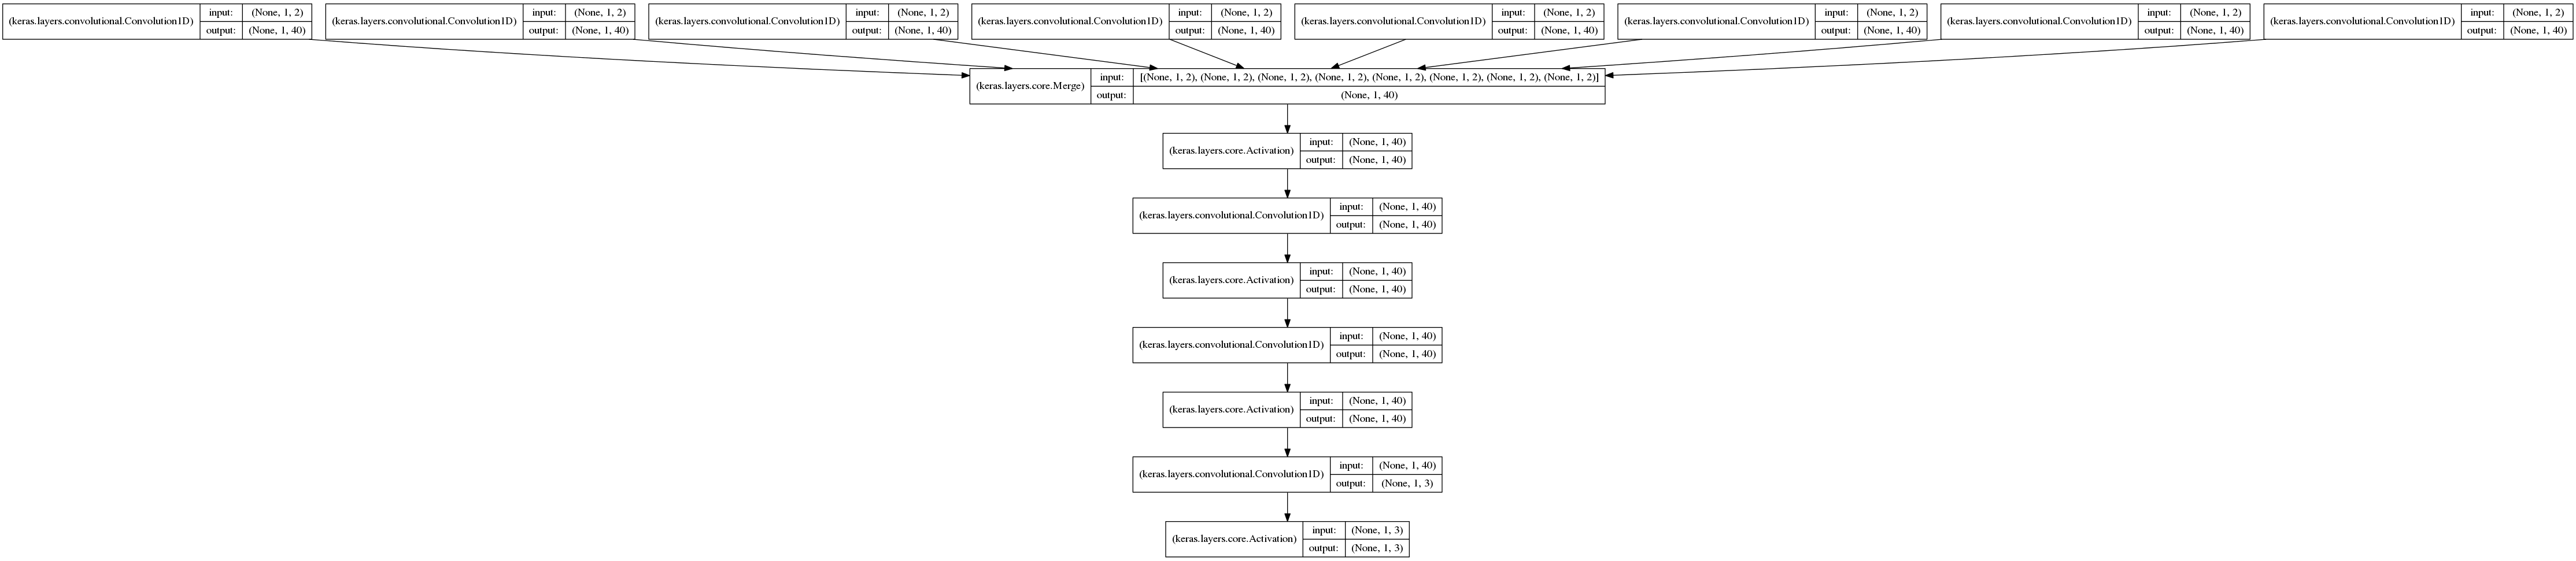

In [85]:
#check your CNN model
from keras.utils.visualize_util import plot
from IPython.display import Image
plot(N_DUDE_CNN, to_file='N_DUDE_CNN'+ '.png', show_shape=True)
Image(filename= 'N_DUDE_CNN' + '.png') 

In [ ]:
from keras import backend as K

inp = N_DUDE_CNN.input                                           # input placeholder
outputs = [layer.output for layer in N_DUDE_CNN.layers[1:]]          # all layer outputs
functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

# Testing
#test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test, 1.]) for func in functors]
print layer_outs

In [ ]:
print layer.output

In [ ]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',input_shape=input_1.shape)) 
convout1= model.add(Activation('relu'))
          
convout1_f = theano.function([model.get_input(train=False)], convout1.get_output(train=False))

In [ ]:
print N_DUDE_CNN.summary()

In [ ]:
Hist = F1.fit(,nb_epoch=1,batch_size=256,show_accuracy=True, verbose=0)

In [ ]:
merged = Merge([one_by_one_1, one_by_one_2, one_by_one_3], mode='concat', concat_axis=1)
merged2 = Merge([merged, one_by_one_4],mode='concat',concat_axis=0)

In [ ]:
tmp = Sequential()
tmp.add(merged)
print tmp.summary()

In [ ]:
print Hist.history['loss']

In [ ]:
a = np.array([1,0])
b = np.array([0,1])

In [ ]:
print a, a.shape
print b, b.shape

In [ ]:
c = vstack((a,b))
print c
d = c.reshape(1,2,2)
print d

In [ ]:
tmp_c, tmp_y = test(P[0],Z[0:512*512],1,L_new[0:2,],2,512*512,offset)

In [ ]:
print tmp_c, tmp_c.shape

In [ ]:
tt = tmp_c.reshape(n-2*512, 2*1, 2)
print tt, tt.shape